#    
# Team 4 Destaurant : Sberbank Russian Housing Market 

###          

 - 팀원 : 허성현, 신정원, 조성빈
 - 주제 : 러시아 Sberbank에서 고객에게 제공하기 위한 러시아 부동산 가격 예측 모델 선정
###            

--------------------------------------------------------------------------------------------------------------------------------

# Contents


|  <h2> 1. Explore Data Analysis <h2/>  |  <h2> 2. Feature Selection <h2/>    | <h2> 3. Model Optimization & Results<h2/>|
| :-------------------------------------- | :-------------------------------------- | :-------------------------------------- |
|  <h3> * Neighbourhood, Macro 변수 탐색 <h3>     | <h3> * 변수 선정 <h3/>                   | <h3> * CV 후 수정 및 모델 분석 <h3/>     |
|  Neighbourhood, Macro                           |  변수선택(Backward Elimination, 반복제거) |  크로스 밸리데이션 및 모델 분석, 수정     |
|  종속, 카테고리, 누메릭 변수              |  R-Style 분석 및 최적화                   |                                        |




 


#          
# 1. EDA 
- 1.1 Basic Data Explore
- 1.2 EDA by Graph

## 1.1 Basic Data Explore

- Train : 21570 rows, 292 columns (2011.08.23 ~ 2015.06.30)
- Macro : 2484 rows, 100 columns (2010.01.01~2016.10.19)
 
### Train (Neighbourhood features) 292


 **종속변수(3)**   id, timestamp, price_doc 
 
**카테고리변수 (24)**
 - 원핫코딩 (11) material, sub_area, ecology, state, ID_railroad_station_walk, ID_big_road1, ID_big_road2, ID_bus_terminal, ID_metro, ID_railroad_station_avto, ID_railroad_terminal
 
  
 - 더미변수 (13) product type, cultuer_objects_top_25, thermal_power_plant_raion, incineration_raion, detention_facility_raion, oil_chemistry_raion, big_market_raion, radiation_raion, nuclear_reactor_raion, water_1line, big_road1_1line, railroad_1line, rail_road_terminal_raion 
 
**누메릭변수 (265)**
 - full_sq, life_sq, num_room, build_year, floor, kitch_sq ...
 
 1. 지역인프라 관련(지역구 구분에 따른 것으로 추정) : 학교수, 병원수, 스포츠센터수 등
 2. 이동거리중심-기간망 관련 : 지하철까지 거리, 상수원까지 거리, 원자력발전소까지 거리 등등
 3. 일정 거리 내의 지표 중심 : 500 ~ 5000 meter 안 공공기관 개수, 쇼핑몰 개수, 카페 및 레스토랑 평균 매출 등등
 4. 인구통계 : 나이 구간별 인구수, 근로종사수, 여성남성 인구수 등등
 5. 건축물 관련 : 구성 자재에 따른 빌딩 수, 건축 년도별 빌딩 수 등등
 6. 기타 : ..

### Macro - economic indicators 100


 **종속변수(1)**   timestamp
  
**누메릭변수 (99)**
 - 유가(oil urals), GDP, 실질GDP, 소비자물가지수, 루블/달러 환율, 지역 부동산 계약 건수, 월평균임금, 출산수, 지역별의사수 등등

## 1.2 EDA by Graph

### Train Null Numbers

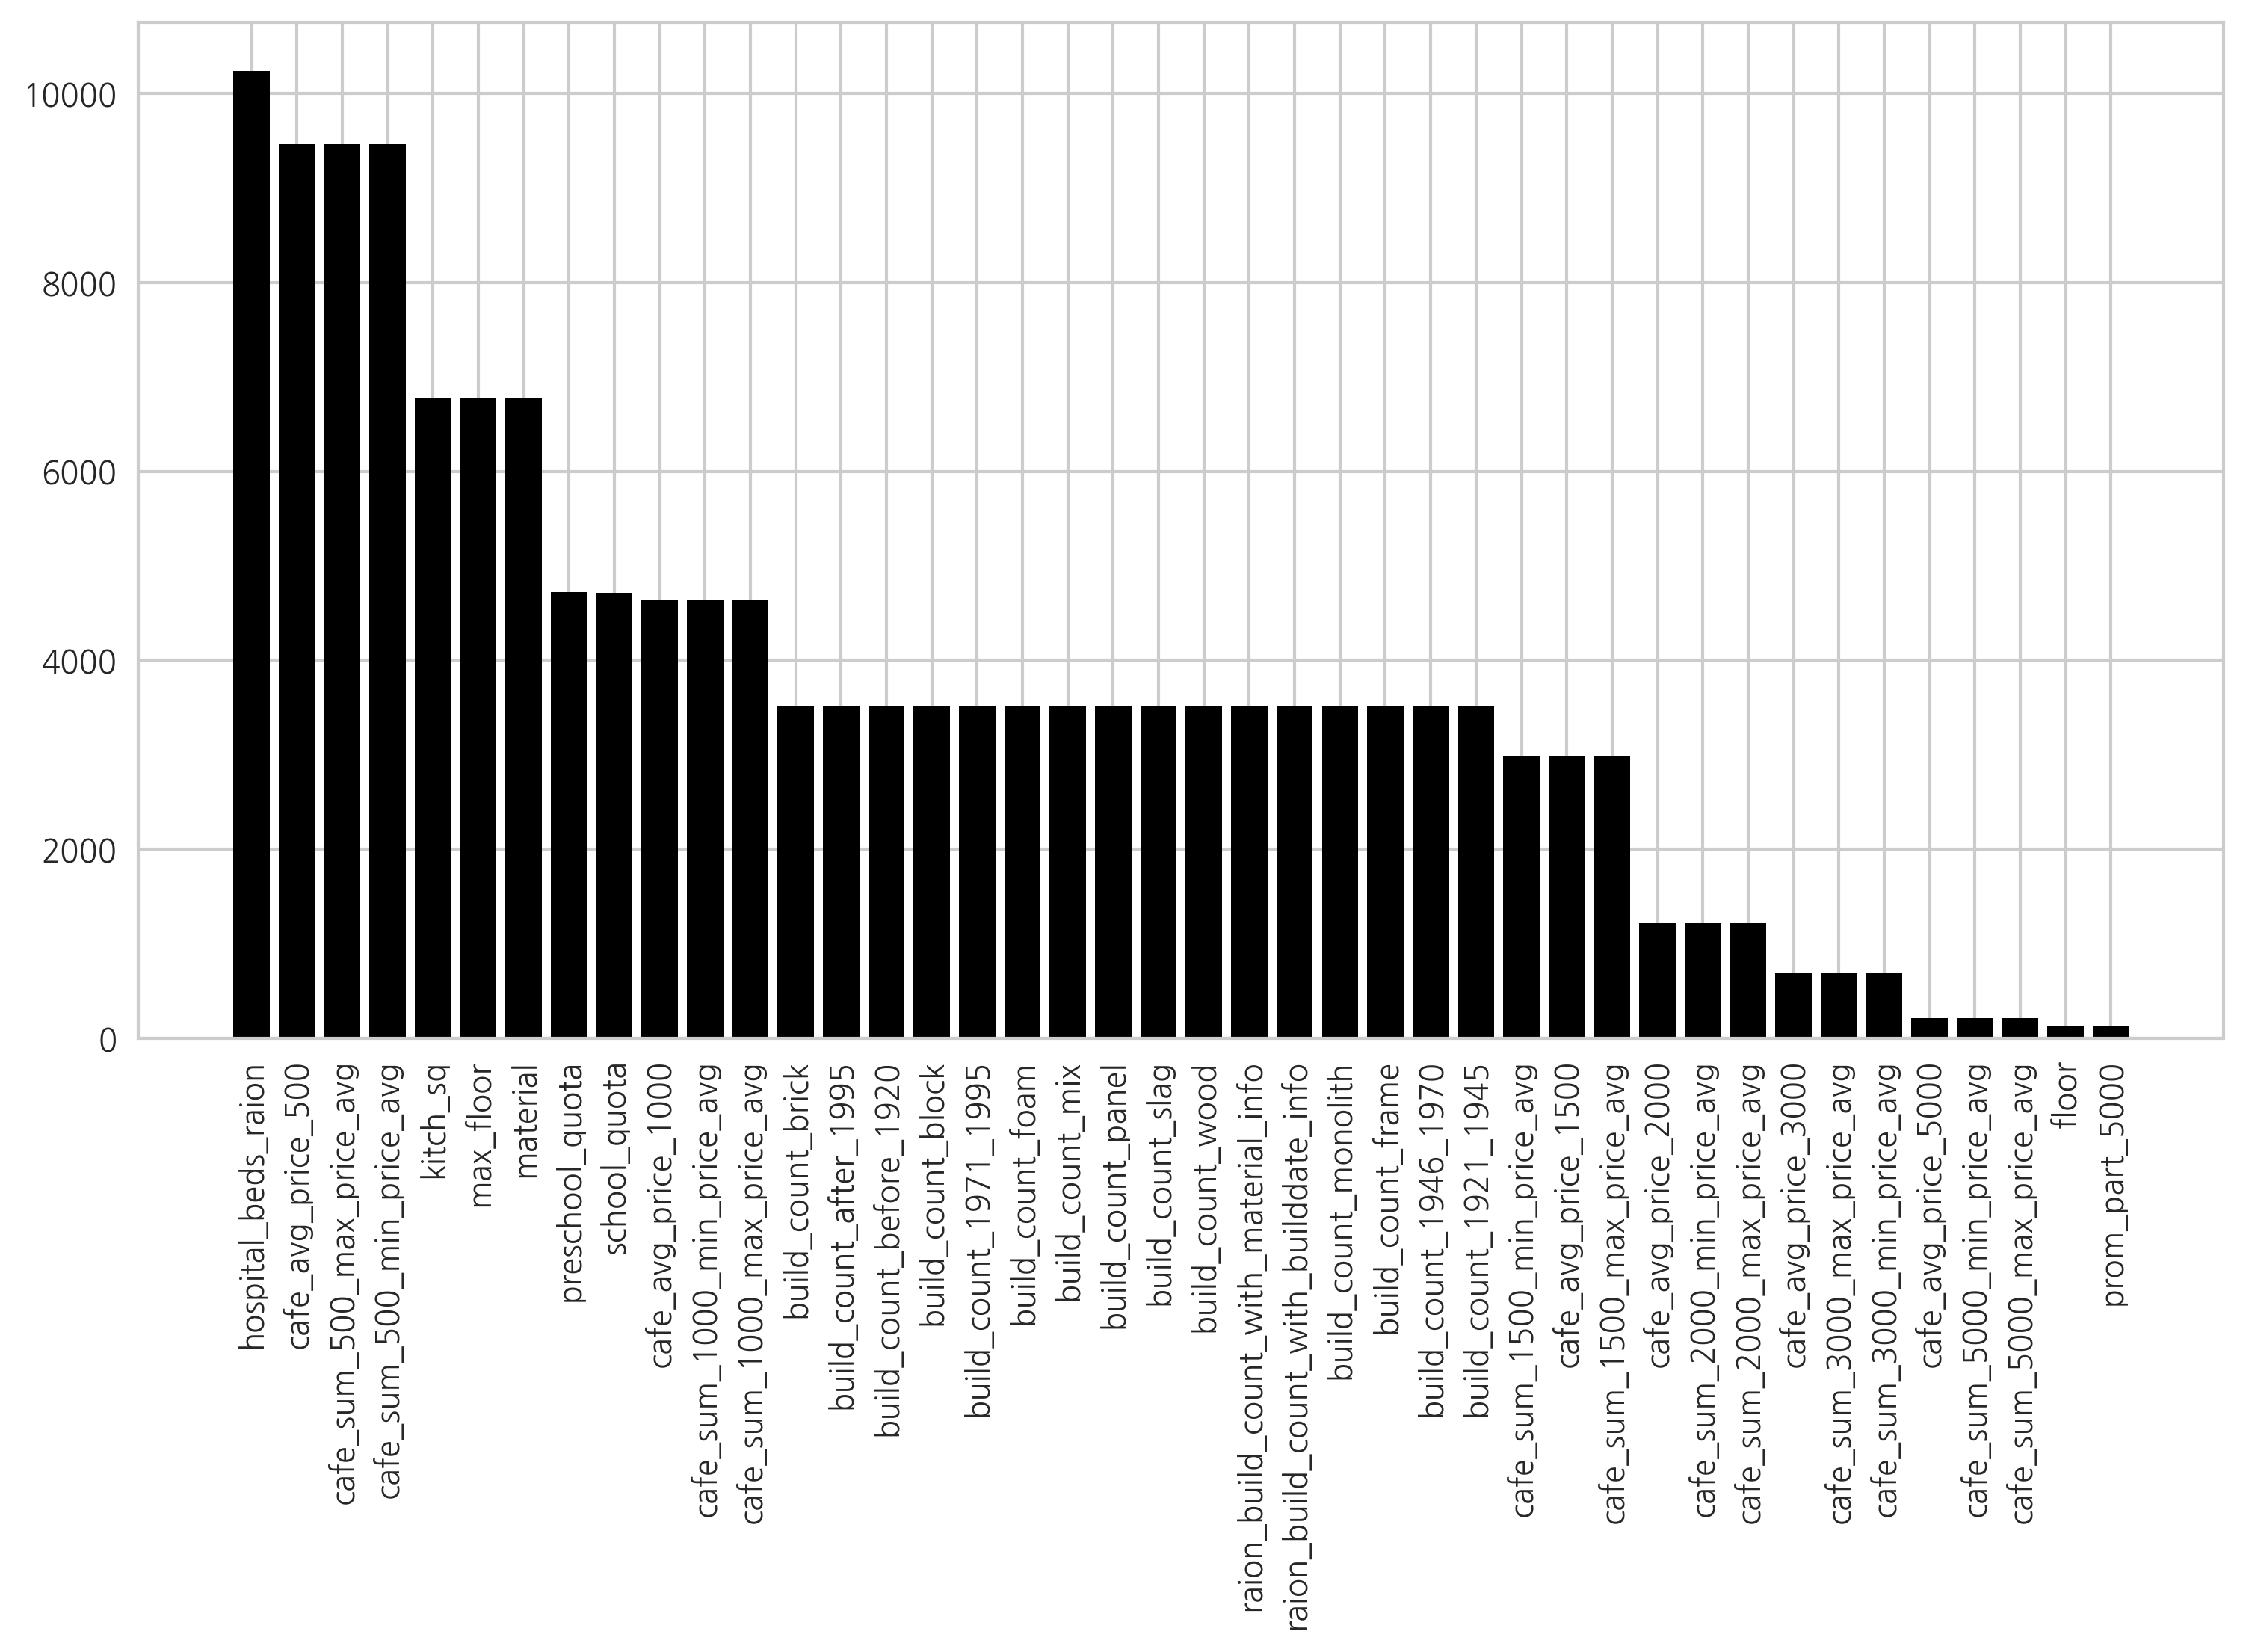

In [8]:
height = train.isnull().sum().sort_values(ascending=False).values[:42]
bars = train.isnull().sum().sort_values(ascending=False).index[:42]
y_nan = np.arange(len(bars))

plt.figure(figsize=(12,6))
# Create bars
plt.bar(y_nan, height, color='black') 
# Create names on the x-axis
plt.xticks(y_nan, bars, rotation='vertical', fontsize=10)
plt.yticks(fontsize=10)
# Show graphic
plt.show()

### price_doc - timestamp

In [9]:
# 그래프 플랏 전 아래 Main cell 실행 요
timeseries = train[['price_doc', 'timestamp']]
timeseries = timeseries.set_index(['timestamp'])
read_timeseries = timeseries.groupby(lambda month : month[:7]).mean()

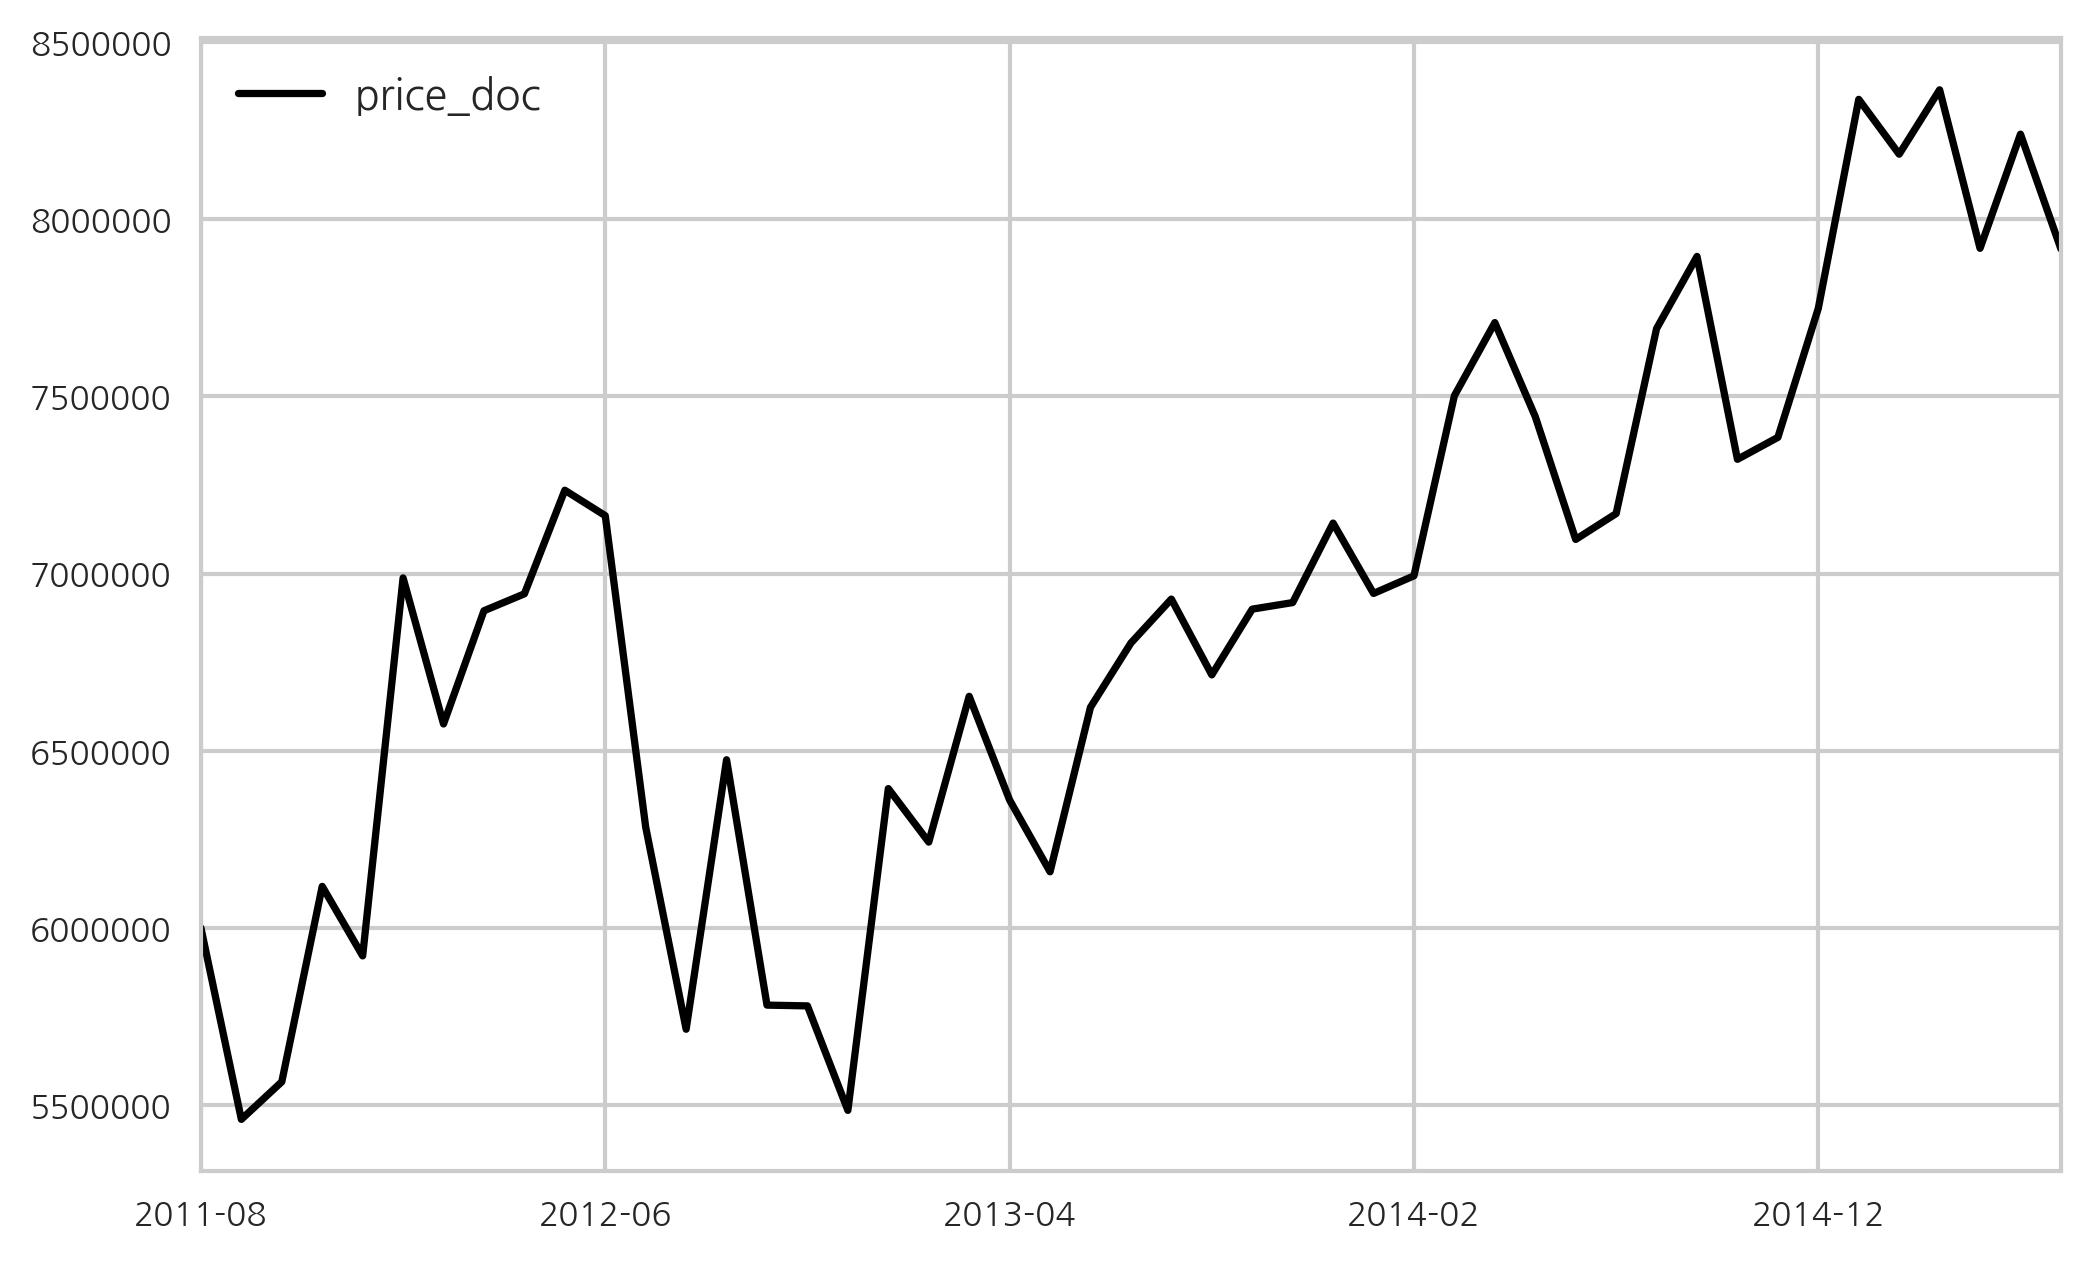

In [11]:
plt.figure(figsize=(12,6))
read_timeseries.plot(fontsize=8, color='black')

### Category - Histogram

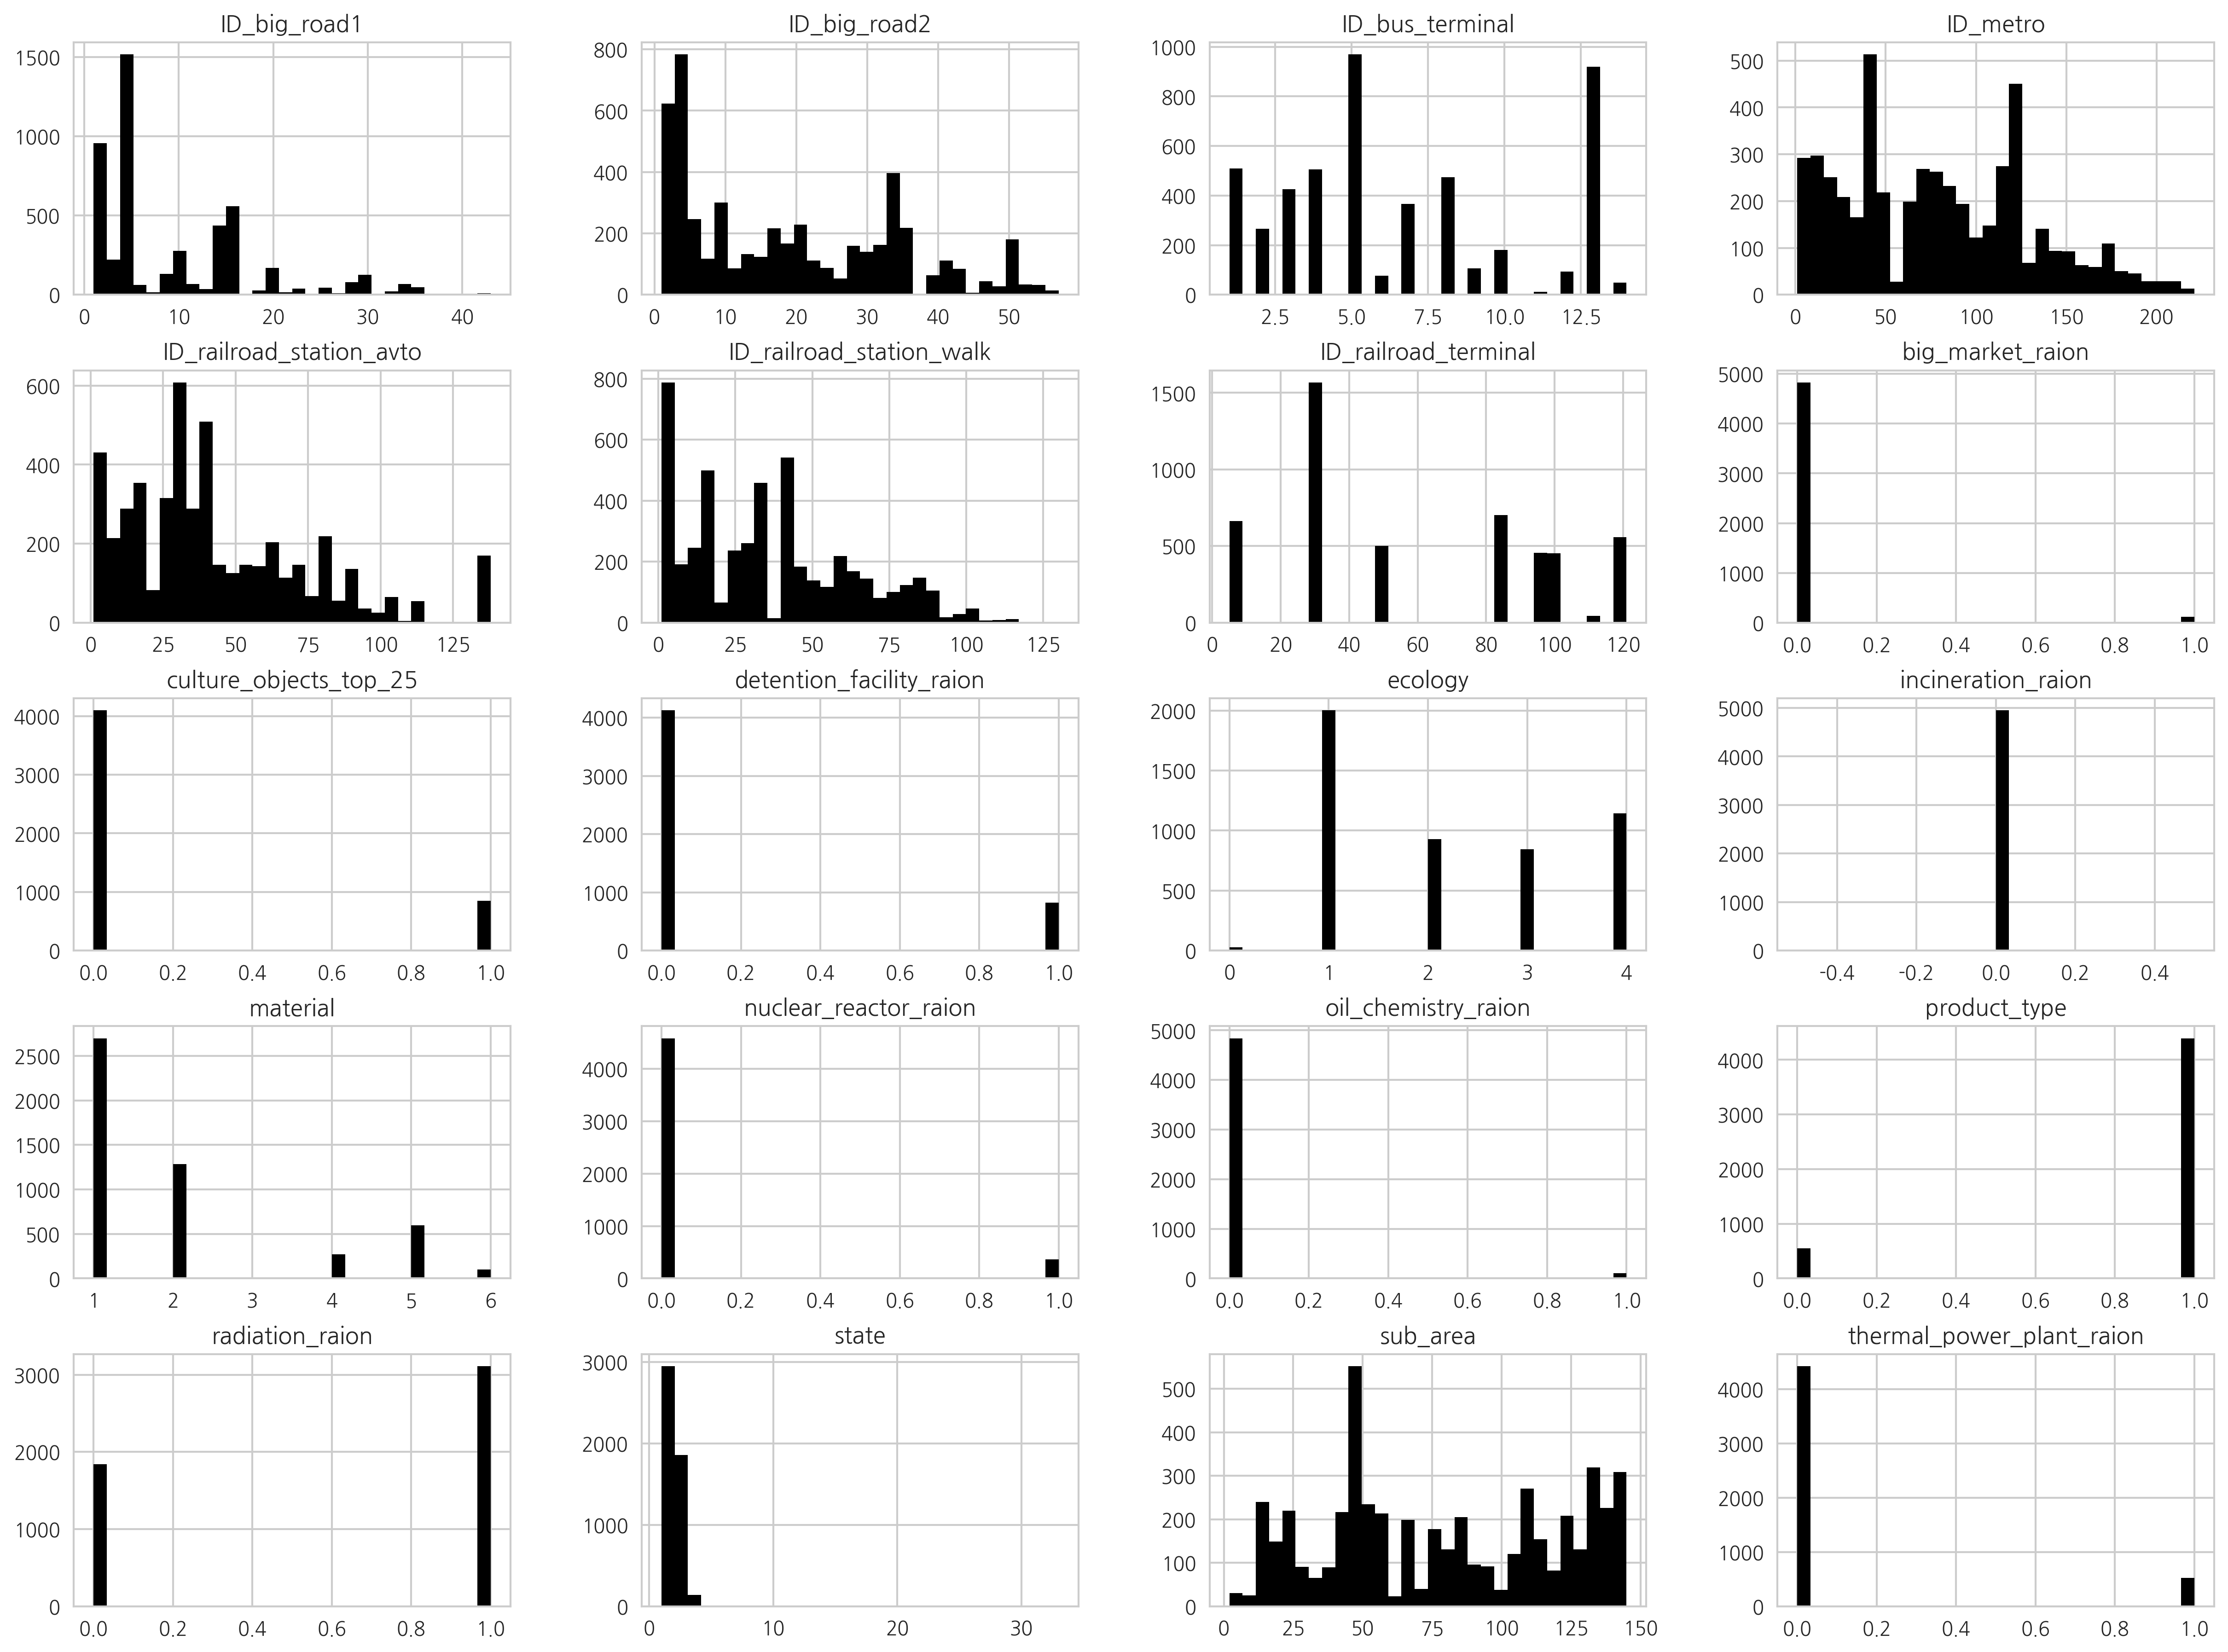

In [319]:
cat_df_for_plot.hist(bins=30, figsize=(20,15), color='black')
plt.show()

### Category - Barplot

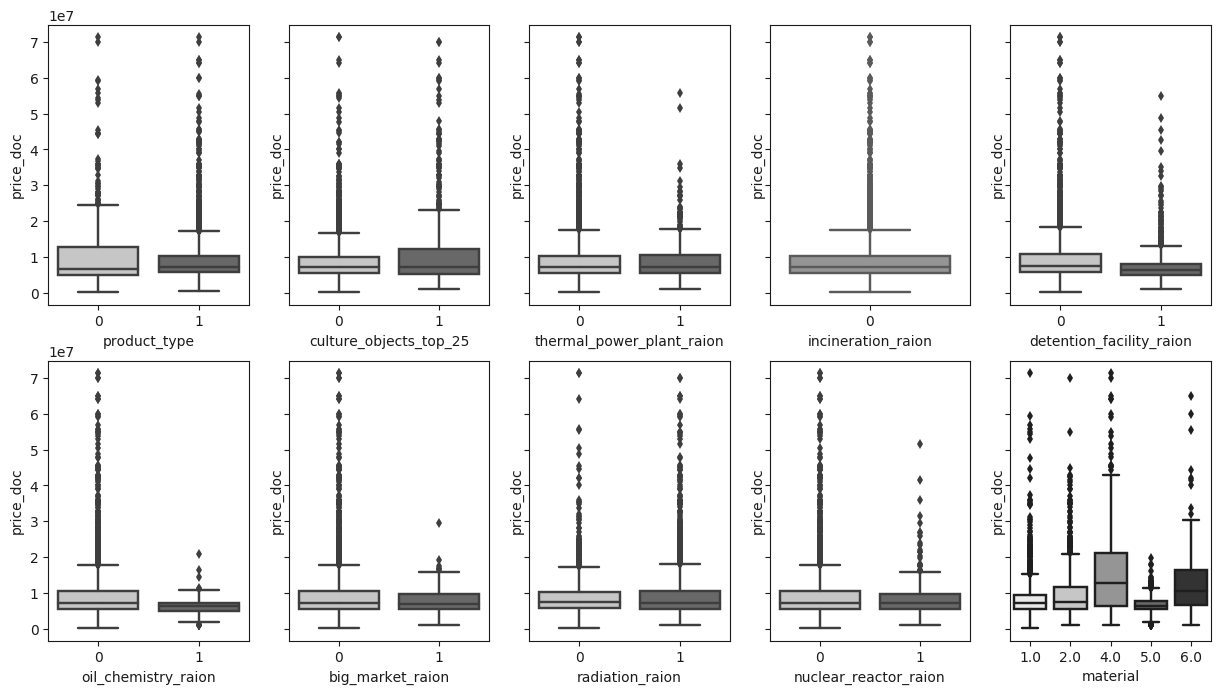

In [16]:
catplot_list = cat_df_for_plot.columns
with plt.style.context(('default')):
    f, axes = plt.subplots(2, 5, figsize=(15, 8), sharey=True)    
     
for num, ax in zip(range(10), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

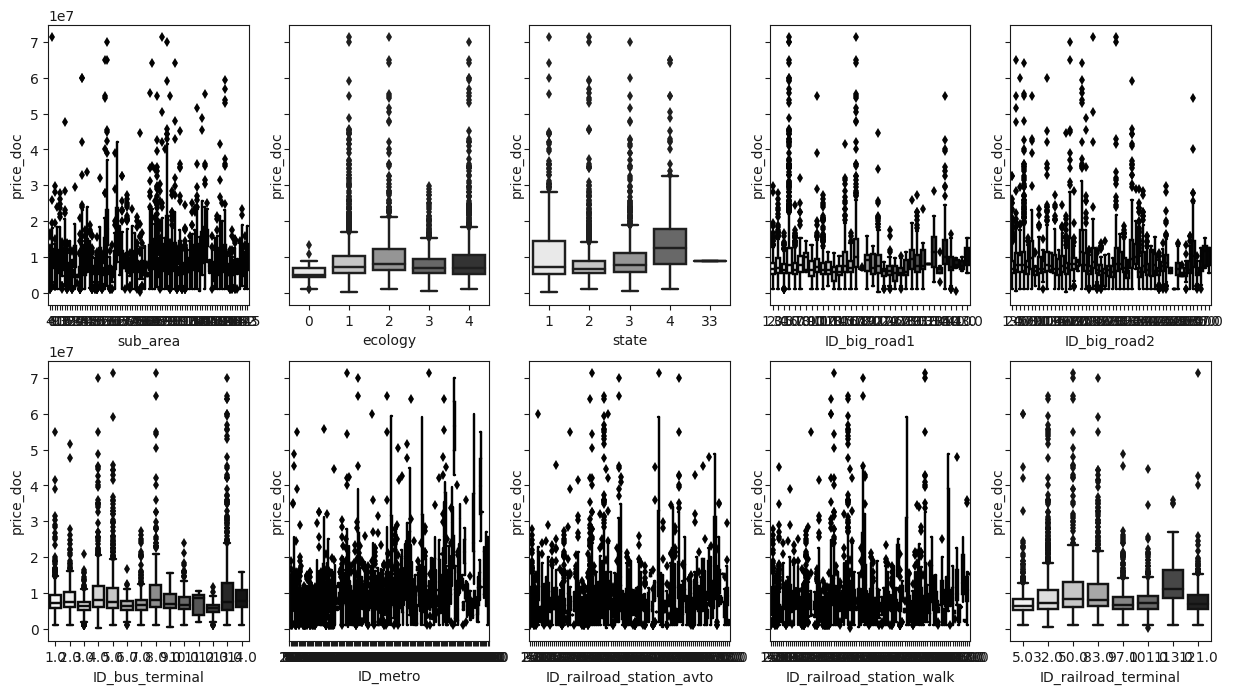

In [17]:
with plt.style.context(('default')):
    f, axes = plt.subplots(2, 5, figsize=(15, 8), sharey=True)    
     
for num, ax in zip(range(10, 20), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

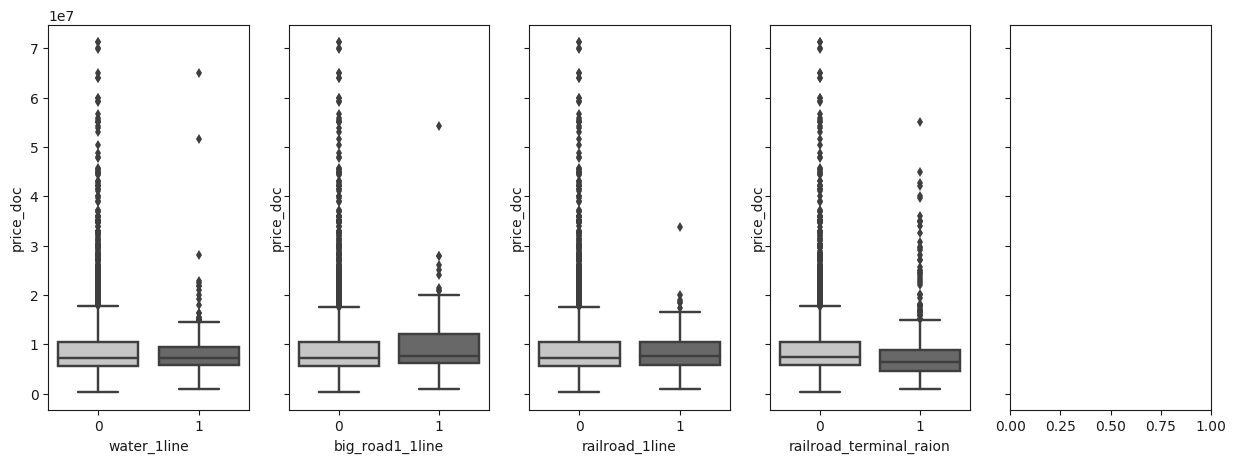

In [18]:
with plt.style.context(('default')):
    f, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)    
     
for num, ax in zip(range(20, 25), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

### Numeric : price_doc - full_sq

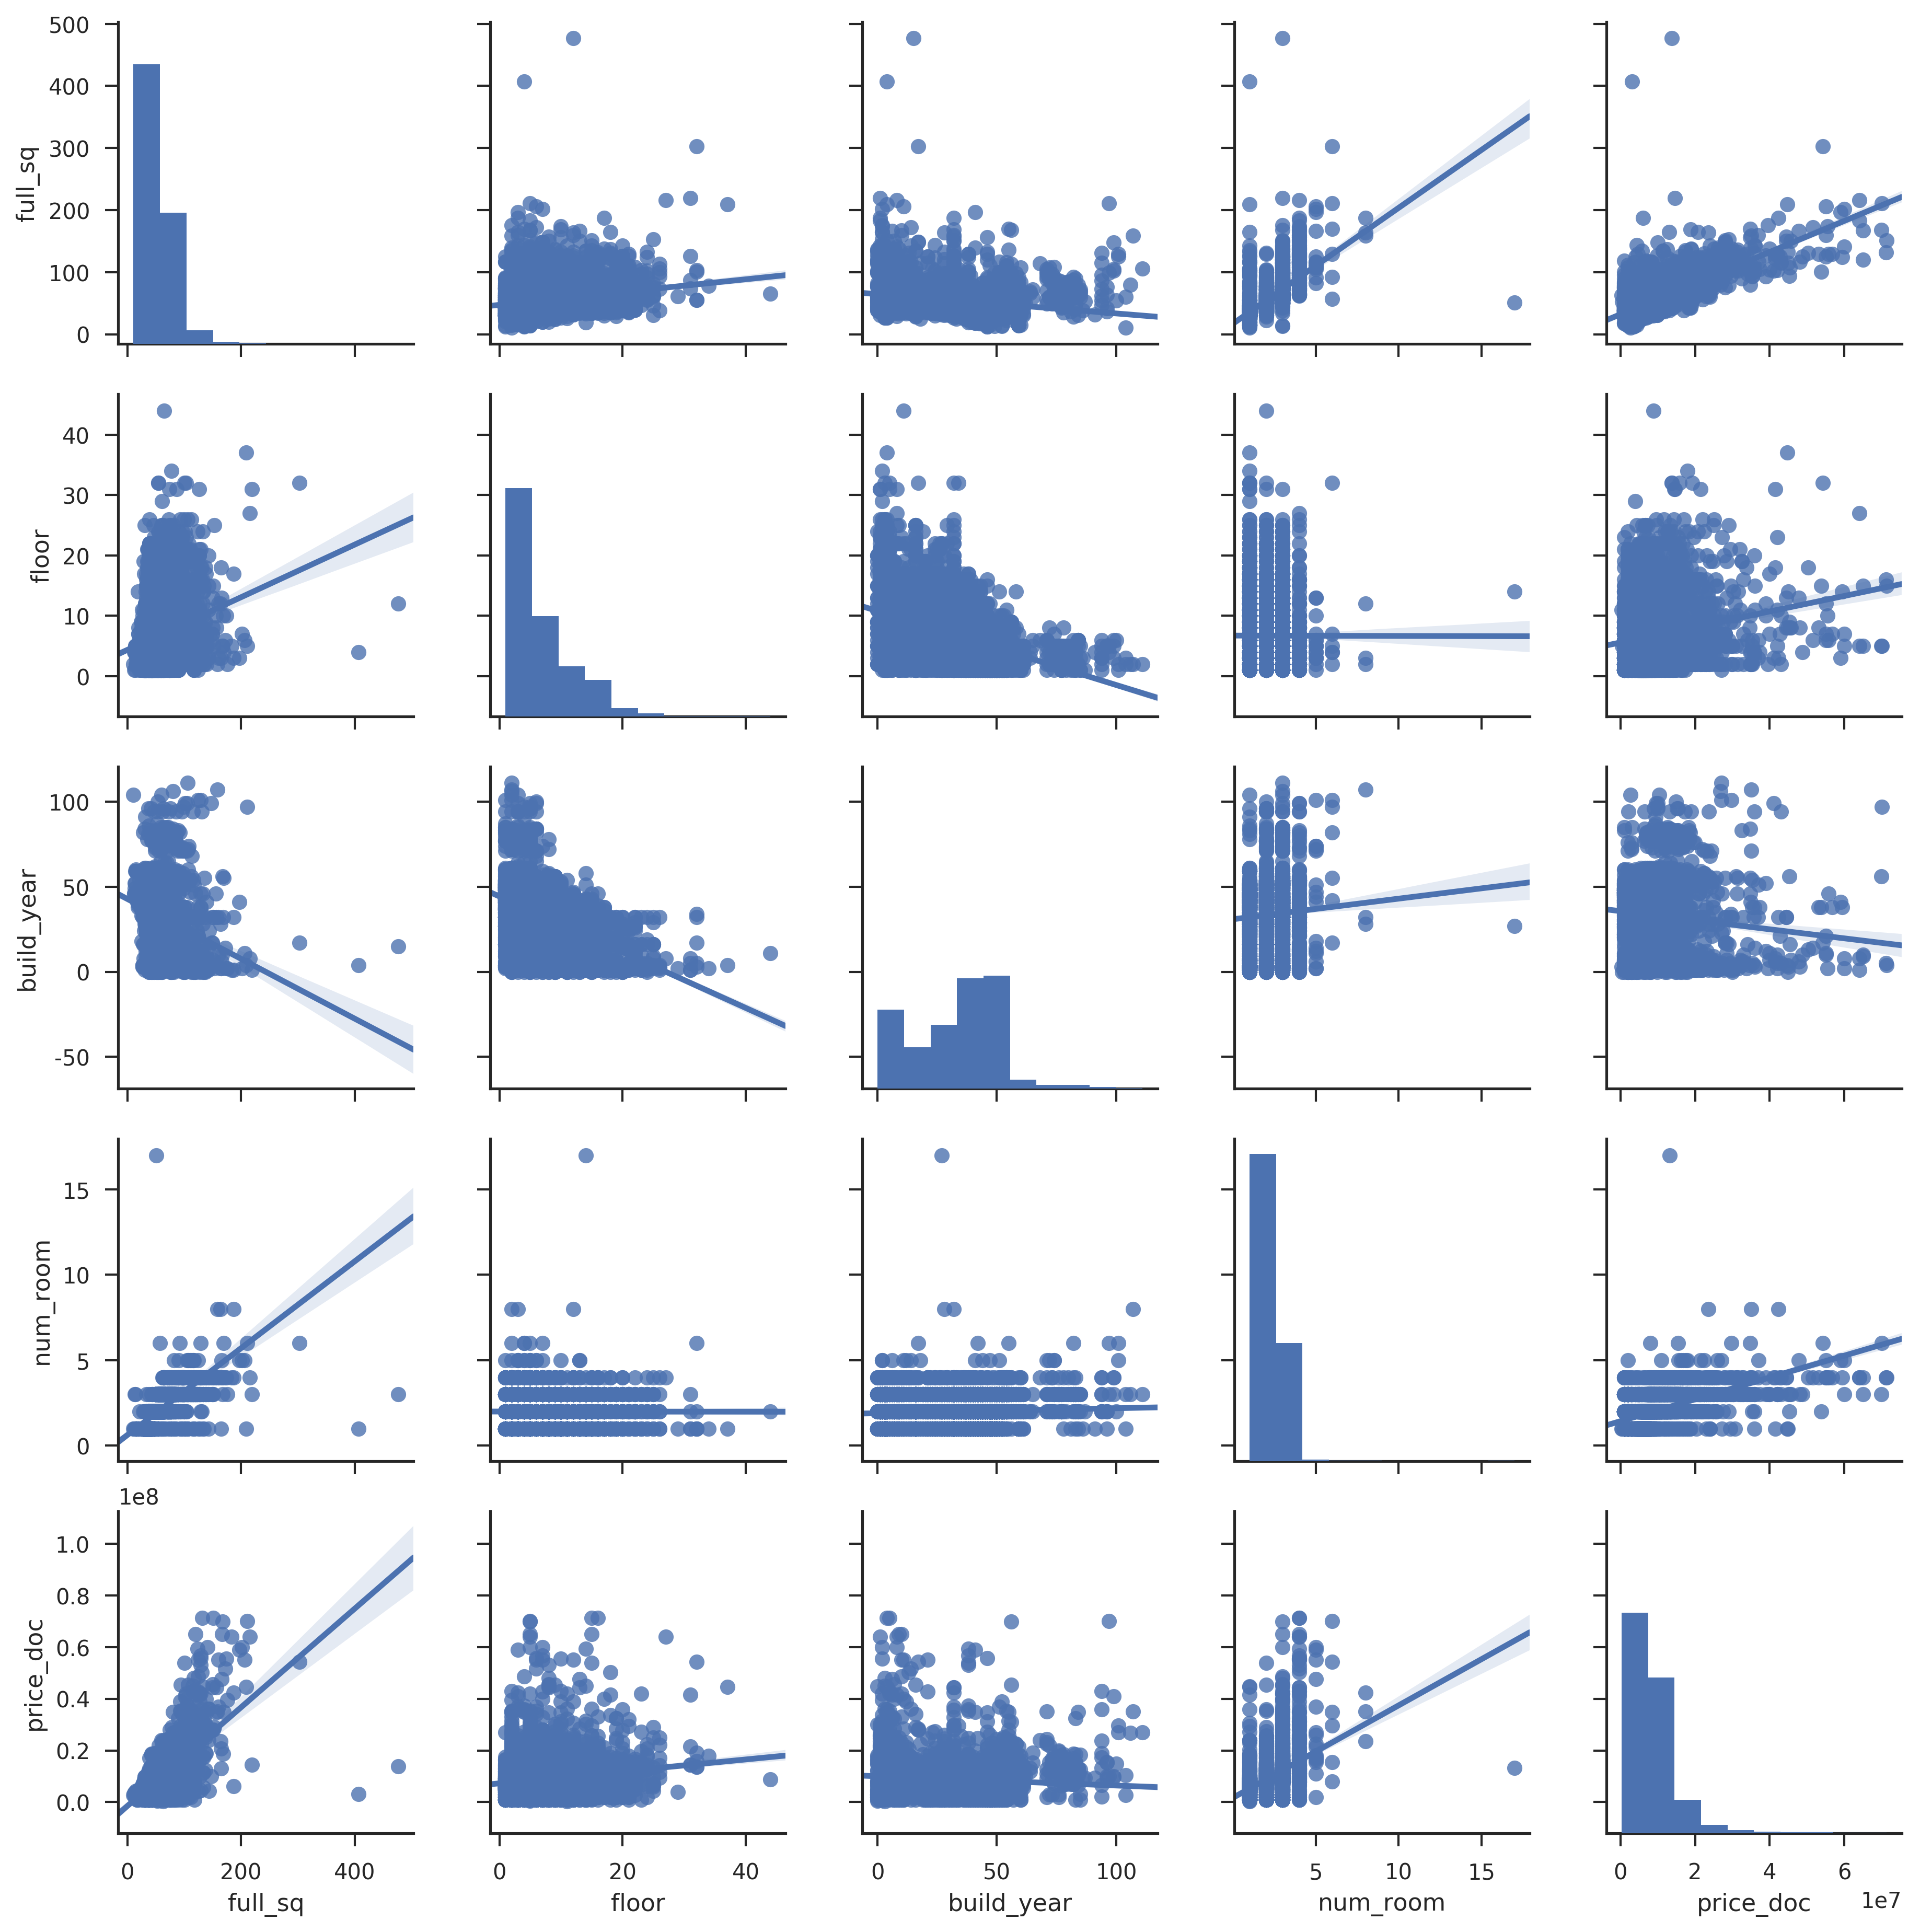

In [105]:
cols = ["full_sq", "floor", "build_year", "num_room", "price_doc"]
sns.set(style="ticks")
g = sns.pairplot(train_df[cols], kind="reg")

#   
# 2. Feature Selection
- 2.1 Neighbourhood Features
- 2.2 Macro Economic Features
- 2.3 Concatenated Features

In [2]:
###############################################  set environment  ###############################################
# pd.set_option('display.height', 1000)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math as m
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import time

###############################################  read data  ###############################################
def read_csv():
    #train = pd.read_csv('datasets/original_data/train.csv')
#     train = pd.read_csv('datasets/processed_data/treated_train_df.csv')
#     train = pd.read_csv('datasets/processed_data/train_df_treated_20171021.csv')
    train = pd.read_csv('datasets/processed_data/train_tr_byear_sta_20171023.csv')

#     m_train = pd.read_csv('datasets/original_data/macro.csv')   
    m_train = pd.read_csv('datasets/processed_data/macro_train_imputated_df_20171023.csv')
    
    t_train = pd.read_csv('datasets/processed_data/t_tr_raw_ma_enc_df.csv')
    return train, m_train, t_train

###############################################  encoding part  ###############################################
#Encoding Categorical Variables
def encode_cat(df):
    """
       Input : train_df 
       Output : encoded_train_df
    """
    #get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()
    
    
    cleanup_nums = {"product_type":{'OwnerOccupier' : 0, 'Investment' : 1},                
               "ecology": {'no data' : 0, 'poor' : 1, 'satisfactory' : 2, 'good' : 3, 'excellent' : 4}}
    
    #dummy encoding
    for i in cat_var_df.columns:        
        if cat_var_df[i].unique()[0] in ['no', 'yes']:
            cleanup_nums[i] = {'no':0, 'yes':1}
    
    #sub_area encoding
    sub_index = 0
    sub_area_enc_dict = {}
    for key in set(cat_var_df['sub_area'].values):
        sub_area_enc_dict[key] = sub_index
        sub_index += 1
    cleanup_nums['sub_area'] = sub_area_enc_dict
    
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        pass
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df

#encode macro cat variable
def m_encode_cat(df):
    """
       Input : macro_df
       Output : encoded_macro_df
    """
    #get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()
    
    
    cleanup_nums = {"child_on_acc_pre_school":{'#!' : 0, '3,013' : 1, '7,311' : 2, '16,765' : 3, '45,713' : 4},                
                "modern_education_share": {'90,92' : 1, '93,08' : 1, '95,4918' : 2},
                "old_education_build_share": {'23,14' : 1, '25,47' : 1, '8,2517' : 2}}
           
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        pass
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df

#encoding numeric var
def encode_num(df):
    """
       Input : train_numeric_variables_column_df
       Output : encoded_train_numeric_variables_column_df
    """
    df['build_year']  = abs(df['build_year'] - 2011) #1900?
    return df

###############################################  outliers handling part  ###############################################
#dropping outliers by fox_criteria
def dropping_outliers1(x, y):
    """
       Input : x = 'independent_variables_df', y = 'dependent_variable_df'
       Process : Remove Outlier-Rows by Fox-Recommendation
       Output : x without Outlier-Rows, y without Outlier-Rows
    """
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(y) - len(x.columns) -1)
    idx = np.where(cooks_d2 > fox_cr)[0]
    x = x.drop(x.index[idx])
    y = y.drop(y.index[idx])
    print("Function dropping_outliers :" + str(len(idx)) + ' rows have beed deleted')
    return x, y

###############################################  feature selection func part  ###############################################
# author : Huh, backward elimination by p-value criteria
def backw_eli(x, y, lim_ = 0.005):
    """
       Input : x = x = 'independent_variables_df', y = 'dependent_variable_df', lim_ = 0.005 'backward p-value limit'
       Process : Greedy backward elimination one by one
       Output : model, result, x = 'final', y
    """
    result_tbl = pd.DataFrame()
    norm_x = pd.DataFrame()
    num_high_pvalue = 1000
    
    for name in x.columns:
        if abs(x[name].max() - x[name].min()) > 3: # avoid category var
            norm_x[name] = (x[name] - x[name].mean())/x[name].std() # (x[name].max() - x[name].min())            

    x1 = norm_x
    
    # x1 = x
    while num_high_pvalue > 0:
        x1 = sm.add_constant(x1)
        model = sm.OLS(y, x1).fit()
        
        sorted_pvalues = model.pvalues.sort_values(ascending=False)
        if sorted_pvalues.index[0] == 'const':
            x1 = x1.drop(sorted_pvalues.index[1], 1)
        else:
            x1 = x1.drop(sorted_pvalues.index[0], 1)
            
        num_high_pvalue = len(model.pvalues[model.pvalues >= lim_])
        
    x = x1.drop(['const'], axis=1)
    model = sm.OLS(y, x1)
    result = model.fit()
        
    return model, result, x, y

# input : x(numeric var), y(dep var), output: x(rank vectors), y(dep_var)
def serial_eli_lim_pval(x, y, ser_1 = 0.0001, ser_2 = 0.6, ser_3 = 0.0005):
    """
       Input : x = x = 'independent_variables_df', y = 'dependent_variable_df', lim_ = 0.005 'backward p-value limit'
       Process : 
       Output : model, result, x = 'final', y
    """
    result_x = []
    
    x1 = x
    remain_var_num = 10    
    while remain_var_num > 0:
        x1 = sm.add_constant(x1)
        result = sm.OLS(y, x1).fit()
        
        #get lowest p-val, delete if in case of const
        sorted_pvalues = result.pvalues.sort_values(ascending=True)
        sorted_pvalues = sorted_pvalues.drop(['const'], axis=0)
        sorted_pvalues_lst = list(sorted_pvalues.index)
        pval_num1_name = sorted_pvalues_lst[0]
        pval_num1_value = sorted_pvalues[0]
        
        #check pval, if it is high enough just delete it and back to while loop
        if pval_num1_value > ser_1:
            x1 = x1.drop([pval_num1_name, 'const'], axis=1)
            remain_var_num = len(x1.columns)            
            
        #
        else:  
            x1 = x1.drop(['const'], axis=1)
            x1_cor = x1.corr()
            x1_cor_eli_lst = list(x1_cor[abs(x1_cor[pval_num1_name]) > ser_2].index)

            if pval_num1_name in x1_cor_eli_lst:
                x1_cor_eli_lst.remove(pval_num1_name)
            x1_pval_eli_lst = list(sorted_pvalues[x1_cor_eli_lst][sorted_pvalues[x1_cor_eli_lst] > ser_3].index)
            x1 = x1.drop([*x1_pval_eli_lst, pval_num1_name], axis=1)

            result_x.append(pval_num1_name)
            remain_var_num = len(x1.columns)
    
    x = x[result_x]
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    
    return model, result, x, y 

#automation of r-style from_formula
def r_style_from_formula_enc_included(num_x, cat_x, y, const=1, scal=0): 
    y_df = pd.DataFrame(y)
    if scal == 0:
        scale_st = ""; scale_en = ""
    else:
        scale_st = "scale("; scale_en = ")"
    
    if const == 0:
        constadd = " + 0" 
    else:
        constadd = ""        
       
    model_str = "price_doc ~ "         
    for i, column in enumerate(num_x.columns):
        if i == 0:
            prefix = ""
        else:
            prefix = " + "
        model_str += prefix + scale_st + column + scale_en
    for i, column in enumerate(cat_x.columns):
        prefix = " + "
        model_str += prefix + "C(" + column + ")"

    df = pd.concat([num_x, cat_x, y_df], axis=1) 
    model_str += constadd
#     print(model_str)
    model = sm.OLS.from_formula(model_str, data=df)
    result = model.fit()
    
    return model, result

#print(poly_string('aaa', 12, True))
#print(poly_string('aaa', 12, False))
def poly_string(var_, deg, scale_=True):
    
    poly_sum = 'scale({})'.format(var_) if scale_ else var_
    for pwr in range(2, deg+1):
        nth_deg = ' + scale(I({}**{}))'.format(var_, pwr) if scale_\
                  else ' + I({}**{})'.format(var_, pwr)
        poly_sum += nth_deg
    return poly_sum

###############################################  result calculation part  ###############################################
#rmsle calculation
def rmsle(y, h): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
     
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [6]:
###############################################  controler part  ###############################################
def auto_eli_and_result_print(x, y, modeltype = 0, ser_1 = 0.0001, ser_2 = 0.6, ser_3 = 0.0005, lim_=0.05):
    if modeltype == 0:
        model, result, x_treat, y = serial_eli_lim_pval(x, y, ser_1, ser_2, ser_3)
    else:
        model, result, x_treat, y = backw_eli(x, y, lim_)
#     x_treat_1 = sm.add_constant(x_treat)
#     y_predict = result.predict(x_treat_1)
#     print('RMSE: ', np.sqrt(metrics.mean_squared_error(y, y_predict)))
#     print('RMSLE', rmsle(y, y_predict))
#     print('R2 : ', result.rsquared, '\n')
#     print('Adj. R2 : ', result.rsquared_adj, '\n')
#     print(result.summary())
    return model, result, x_treat, y

###############################################  operation part  ###############################################

# call data set
train, m_train, t_train = read_csv() 

#encode cat variable
train_df_enc = encode_cat(train)
m_train_df_enc = m_encode_cat(m_train)
t_train_df_enc_cat = encode_cat(t_train)
t_train_df_enc_cat_num = encode_num(t_train_df_enc_cat)

#encode num variable & drop Null rows
train_df = encode_num(train_df_enc).dropna(how='any')


#merging 1 : macro with price_doc,timestamp
price_time_df = train[['timestamp', 'price_doc']]
m_train_df_enc_merge = pd.merge(m_train_df_enc, price_time_df, how='inner', on='timestamp')

#variable dividing train (dep, cat, num & dum)
dep_df = train_df[['id', 'timestamp', 'price_doc']]
cat_df = train_df[['material', 'sub_area', 'ecology', 'state', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', \
                   'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 'ID_railroad_terminal']]
cat_df_for_plot = train_df[['product_type', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 
                    'detention_facility_raion', 'oil_chemistry_raion', 'big_market_raion', 'radiation_raion', 
                    'nuclear_reactor_raion', 'material', 'sub_area', 'ecology', 'state', 'ID_big_road1', 'ID_big_road2', 
                    'ID_bus_terminal', 'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 
                    'ID_railroad_terminal', 'water_1line', 'big_road1_1line', 'railroad_1line', 'railroad_terminal_raion' ]]
num_dum_df = train_df.drop([*dep_df.columns, *cat_df.columns], axis=1)
y_df = dep_df['price_doc']   
y_log = np.log(y_df)

#variable dividing macro
m_dep_df = m_train_df_enc_merge[['price_doc', 'timestamp']]
# m_cat_df = m_train_df_enc_merge[['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']]
m_num_dum_df = m_train_df_enc_merge.drop([ *m_dep_df.columns], axis=1) # *m_cat_df.columns,
m_y = m_dep_df.price_doc

#num_dum_df, dep outliers cleasing & cat_var rows cleansing following num_dum_df  :  train
num_dum_df_do1, y_do1 = dropping_outliers1(num_dum_df, y_df)
cat_df_do1 = cat_df.loc[num_dum_df_do1.index, :]
dep_df_do1 = dep_df.loc[num_dum_df_do1.index, :]
y_do1_log = np.log(y_do1)

#num_dum_df, dep outliers cleasing & cat_var rows cleansing following num_dum_df  :  macro
m_num_dum_df_do1, m_y_do1 = dropping_outliers1(m_num_dum_df, m_y)
# m_cat_df_do1 = m_cat_df.loc[m_num_dum_df_do1.index, :]
m_dep_df_do1 = m_dep_df.loc[m_num_dum_df_do1.index, :]

#merging 2 : train with macro
temp_for_mgr_num_dum_df_do1 = pd.concat([num_dum_df_do1, cat_df_do1, dep_df_do1], axis=1)
temp_for_mgr_m_num_dum_df_do1 = pd.concat([m_num_dum_df_do1, m_dep_df_do1], axis=1)
temp_for_mgr_m_num_dum_df_do1_grouped = temp_for_mgr_m_num_dum_df_do1.groupby('timestamp').aggregate(np.mean).drop(['price_doc'],  axis=1)
train_mrg_macro_df = pd.merge(temp_for_mgr_num_dum_df_do1, temp_for_mgr_m_num_dum_df_do1_grouped, how='left', left_on='timestamp', right_index=True)

#variable dividing total
t_dep_df = train_mrg_macro_df[['id', 'timestamp', 'price_doc']]
t_cat_df = train_mrg_macro_df[['material', 'sub_area', 'ecology', 'state', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', \
                   'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 'ID_railroad_terminal']]
t_num_dum_df = train_mrg_macro_df.drop([*t_cat_df.columns, *t_dep_df.columns], axis=1)
t_y = t_dep_df[['price_doc']]

print(train_mrg_macro_df.shape)

Function dropping_outliers :251 rows have beed deleted
Function dropping_outliers :279 rows have beed deleted
(4699, 391)


##        
## 2.1 Neighbourhood Features
- 2.1.1 Numeric Variable Selection
- 2.1.2 Categorical Variable Selection

## Numeric Variable Selection (With Loop)

### Forward Selection - Serial Loop

In [7]:
model1, result1, x1, y1 = auto_eli_and_result_print(num_dum_df_do1, y_do1, modeltype=0, ser_1=0.000001, ser_2=0.7, ser_3=0.000001)


/home/dockeruser/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [8]:
print(result1.summary()) 

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     524.0
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:43:21   Log-Likelihood:                -76725.
No. Observations:                4699   AIC:                         1.535e+05
Df Residuals:                    4682   BIC:                         1.536e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [50]:
result1.params.index

Index(['const', 'full_sq', 'kitch_sq', 'product_type', 'build_year',
       'max_floor', 'floor', 'kremlin_km', 'mosque_count_3000',
       'cafe_count_500_price_high', 'office_count_500', 'leisure_count_500',
       'full_all', 'railroad_km', 'build_count_brick', 'indust_part',
       'cafe_avg_price_2000'],
      dtype='object')

### Backward Elimination

In [4]:
model2, result2, x2, y2 = auto_eli_and_result_print(num_dum_df_do1, y_do1, modeltype = 1, lim_=0.000001)

In [5]:
print(result2.summary()) 

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     601.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        13:53:21   Log-Likelihood:                -76322.
No. Observations:                4699   AIC:                         1.527e+05
Df Residuals:                    4680   BIC:                         1.528e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

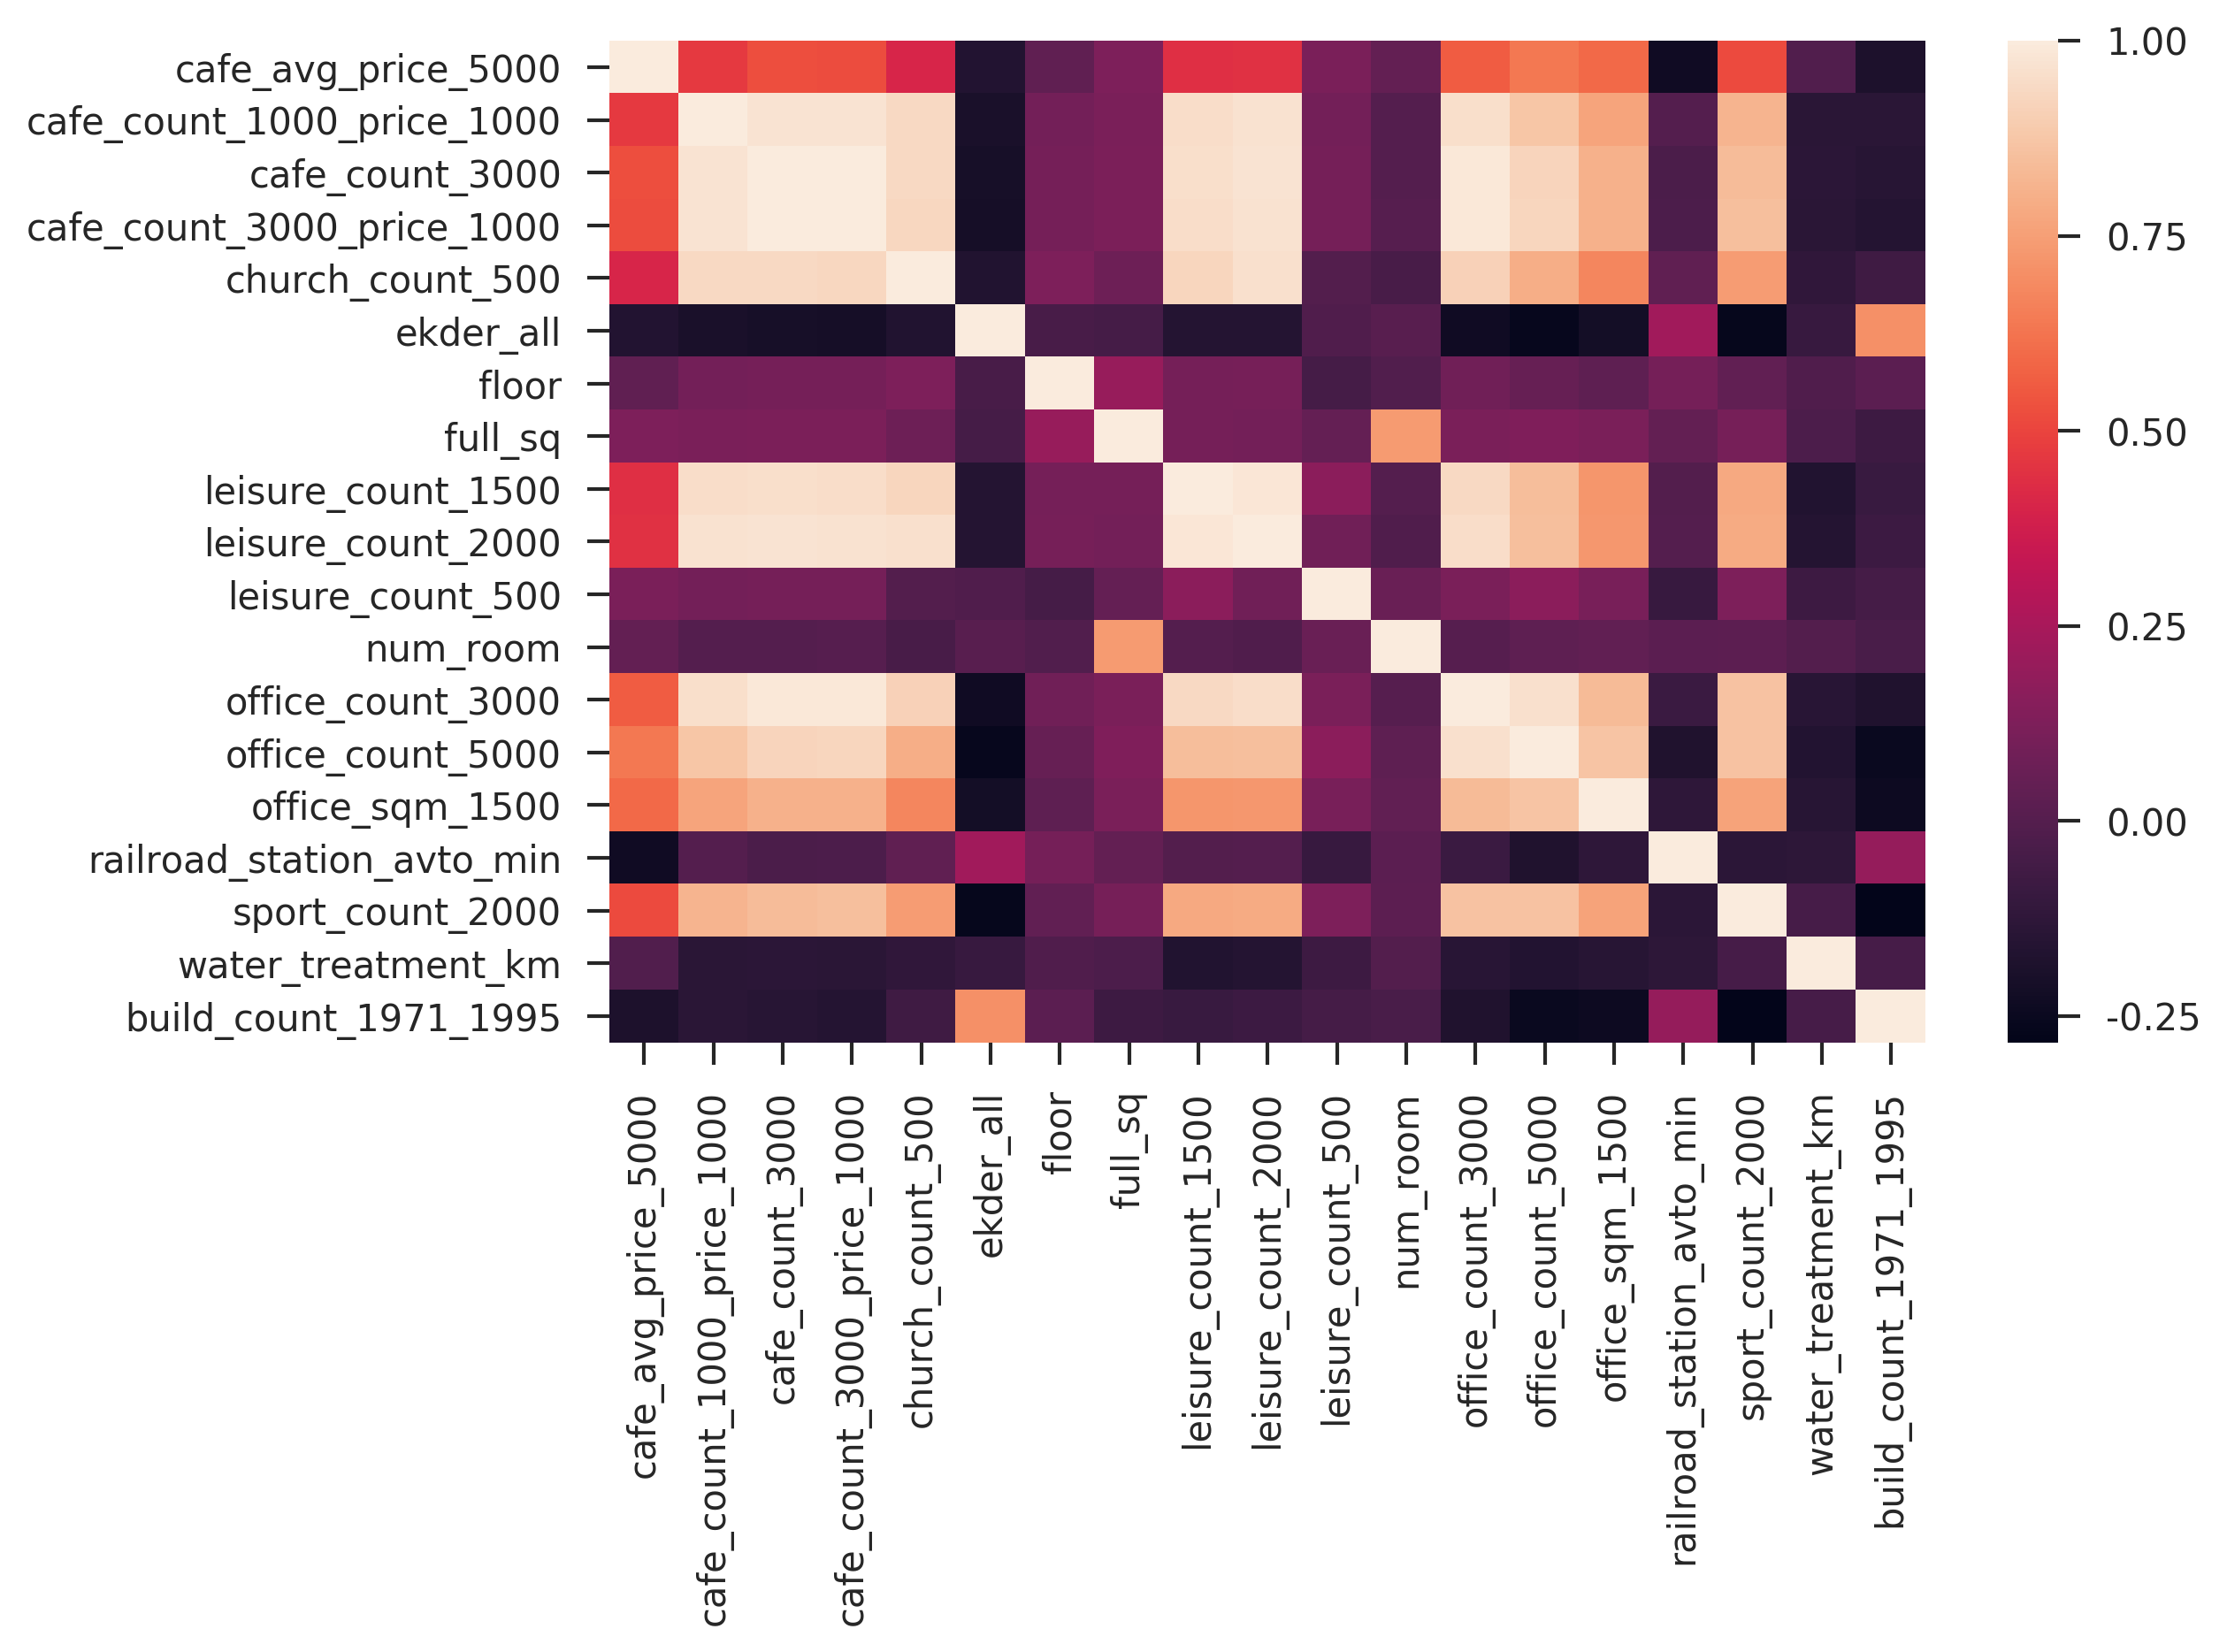

In [97]:
be_temp_df = num_dum_df_do1[['cafe_avg_price_5000', 'cafe_count_1000_price_1000',
       'cafe_count_3000', 'cafe_count_3000_price_1000', 'church_count_500',
       'ekder_all', 'floor', 'full_sq', 'leisure_count_1500',
       'leisure_count_2000', 'leisure_count_500', 'num_room',
       'office_count_3000', 'office_count_5000', 'office_sqm_1500',
       'railroad_station_avto_min', 'sport_count_2000', 'water_treatment_km',
       'build_count_1971_1995']]
sns.heatmap(be_temp_df.corr())
plt.show()

## Further Variable drop, manually

In [51]:
tr1_x = num_dum_df_do1[['full_sq', 'kitch_sq', 'product_type', 'build_year',
       'max_floor', 'floor', 'cafe_count_1500_price_4000', 'kremlin_km',
       'leisure_count_500', 'preschool_education_centers_raion', 'cafe_sum_3000_max_price_avg']]
tr1_x1 = sm.add_constant(tr1_x)
result = sm.OLS(y_do1, tr1_x1).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     782.6
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:46:37   Log-Likelihood:                -76687.
No. Observations:                4699   AIC:                         1.534e+05
Df Residuals:                    4687   BIC:                         1.535e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## R-Style from_formula with auto-encoding function

In [54]:
r_model1, r_result1 = r_style_from_formula_enc_included(tr1_x, cat_df_do1[['ecology', 'material']], y_do1, const=1, scal=1)
print(r_result1.summary())

r_temp_df = pd.concat([tr1_x1, cat_df_do1[['ecology', 'material']]], axis=1)
r_temp_df_x1 = sm.add_constant(r_temp_df)
y_new = r_result1.predict(r_temp_df_x1)
# rmsle(y_do1, y_new)
print(np.sqrt(metrics.mean_squared_error(y_do1, y_new)))

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     476.0
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:48:55   Log-Likelihood:                -76609.
No. Observations:                4699   AIC:                         1.533e+05
Df Residuals:                    4679   BIC:                         1.534e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### 2nd Outlier Dropping with dropping_outliers function

In [55]:
r_temp_1024_dfx = pd.concat([tr1_x, cat_df_do1[['ecology', 'material']]], axis=1)
r_temp_1024_dfx_do2, y_do2 = dropping_outliers1(r_temp_1024_dfx, y_do1)
tr2_do2_dfx = r_temp_1024_dfx_do2.drop(['ecology', 'material'], axis=1)
cat_tr2_do2_dfx = r_temp_1024_dfx_do2[['ecology', 'material']]

r_model2, r_result2 = r_style_from_formula_enc_included(tr2_do2_dfx, cat_tr2_do2_dfx, y_do2, const=1, scal=1)
print(r_result2.summary())

r_temp_1024_dfx1_do2 = sm.add_constant(r_temp_1024_dfx_do2)
y_new2 = r_result2.predict(r_temp_1024_dfx1_do2)
np.sqrt(metrics.mean_squared_error(y_do2, y_new2))    


Function dropping_outliers :346 rows have beed deleted
                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     596.2
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        10:51:49   Log-Likelihood:                -69643.
No. Observations:                4353   AIC:                         1.393e+05
Df Residuals:                    4333   BIC:                         1.395e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

2147866.3628491648

In [56]:
r_result2.params.index

Index(['Intercept', 'C(ecology)[T.1]', 'C(ecology)[T.2]', 'C(ecology)[T.3]',
       'C(ecology)[T.4]', 'C(material)[T.2.0]', 'C(material)[T.4.0]',
       'C(material)[T.5.0]', 'C(material)[T.6.0]', 'scale(full_sq)',
       'scale(kitch_sq)', 'scale(product_type)', 'scale(build_year)',
       'scale(max_floor)', 'scale(floor)', 'scale(cafe_count_1500_price_4000)',
       'scale(kremlin_km)', 'scale(leisure_count_500)',
       'scale(preschool_education_centers_raion)',
       'scale(cafe_sum_3000_max_price_avg)'],
      dtype='object')

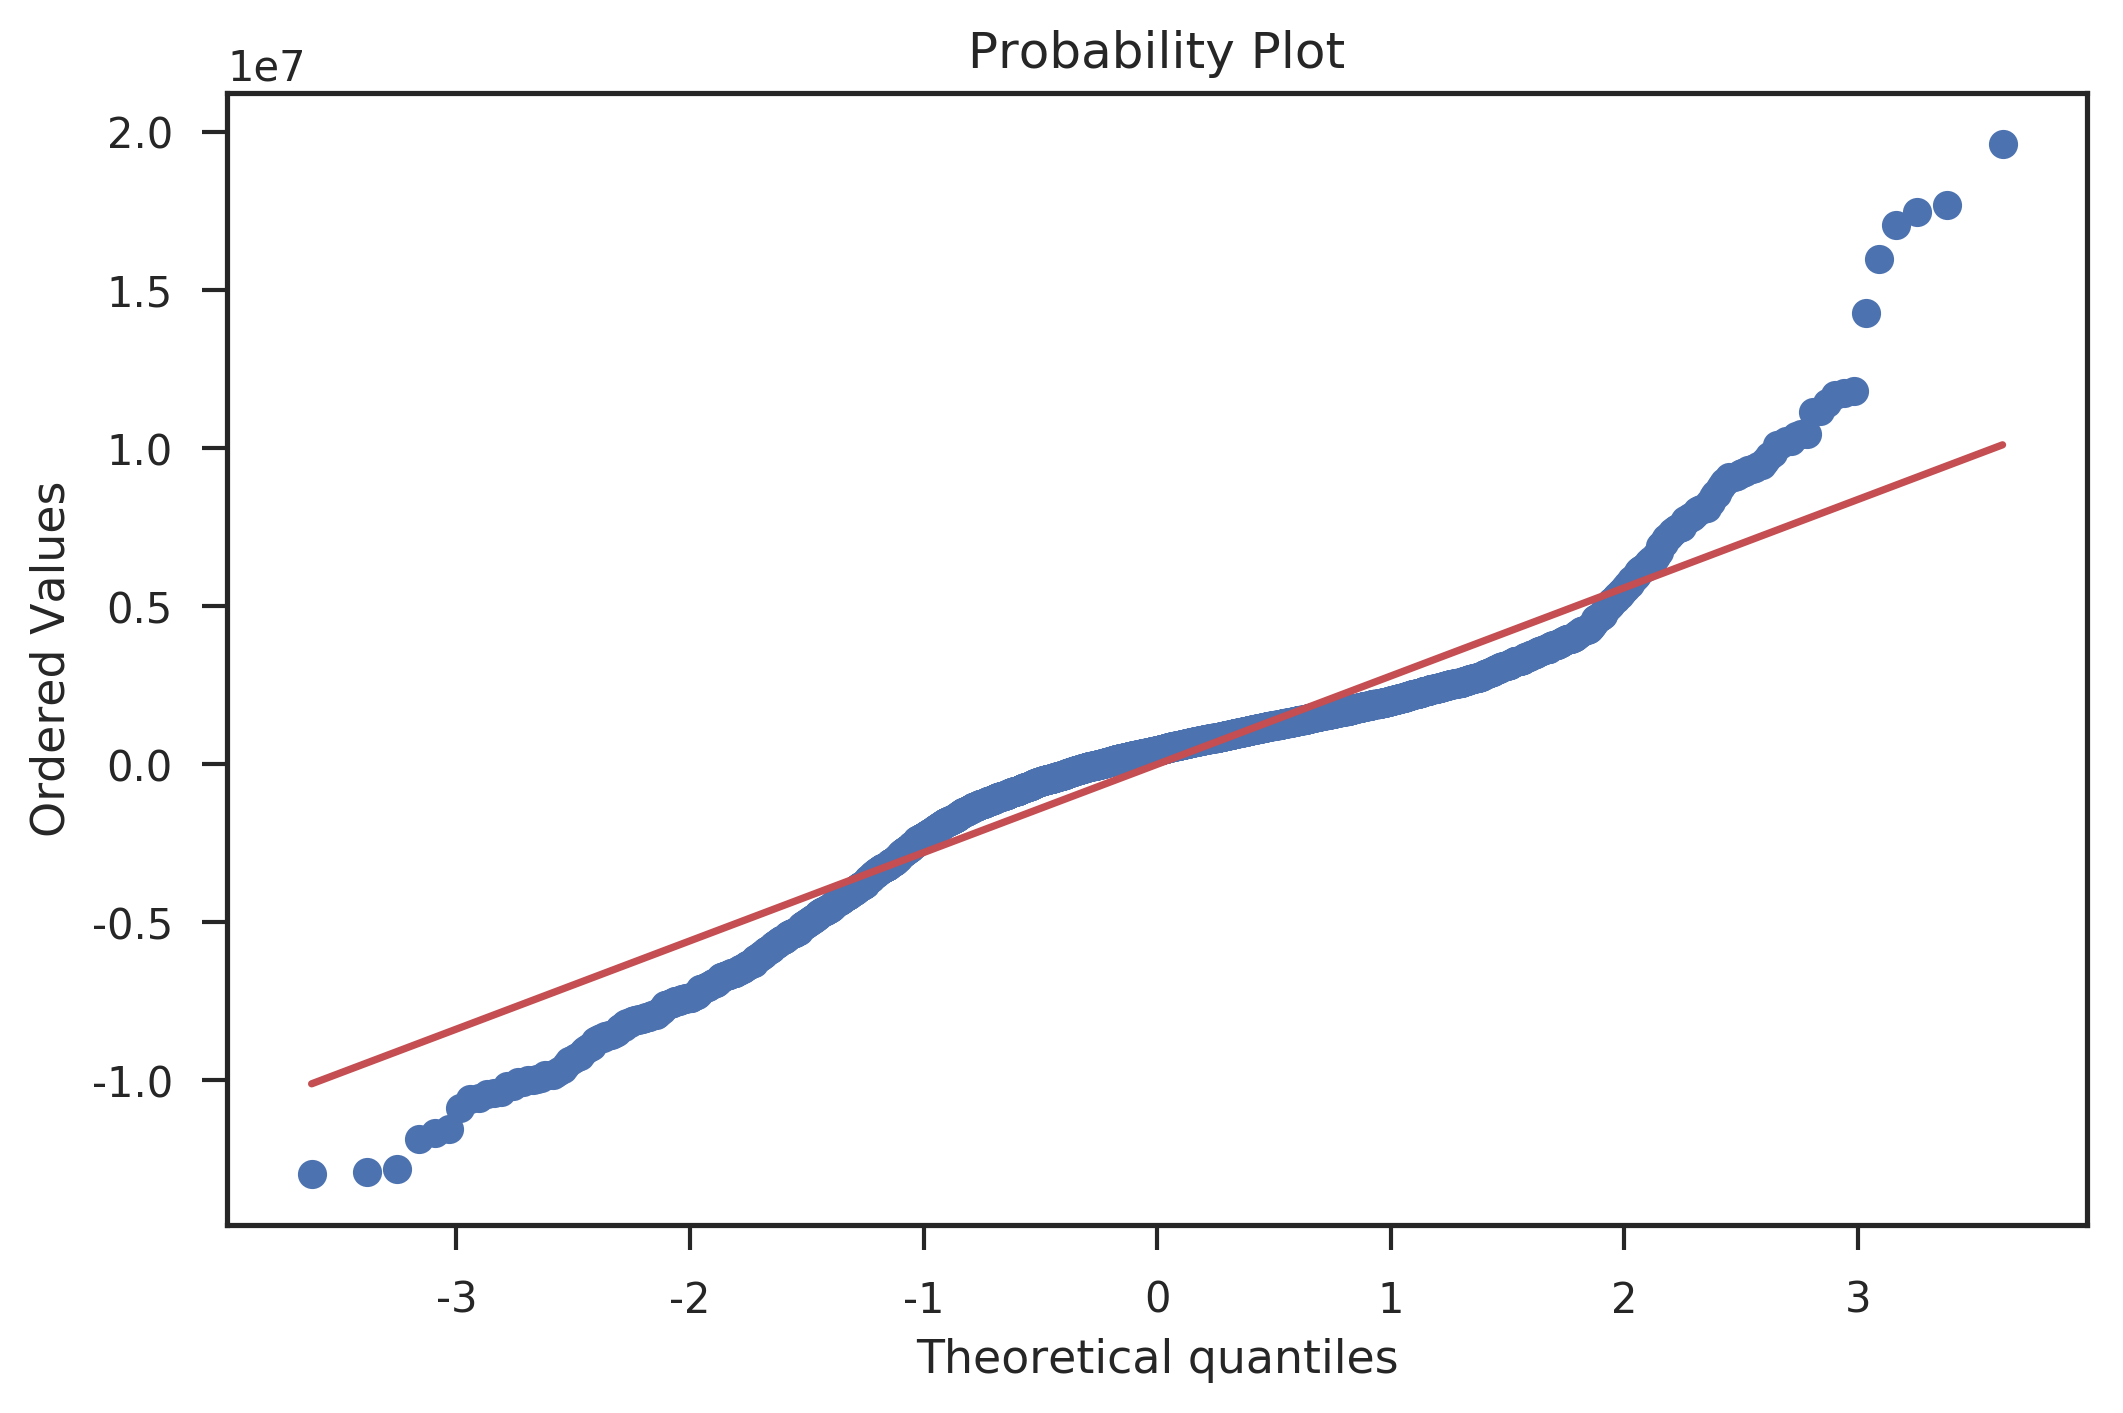

In [64]:
sp.stats.probplot(r_result1.resid, plot=plt)
plt.figure(figsize=(8,5))
plt.show()

In [65]:
test = sms.omni_normtest(r_result1.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 477.320
P-value     :  0.000


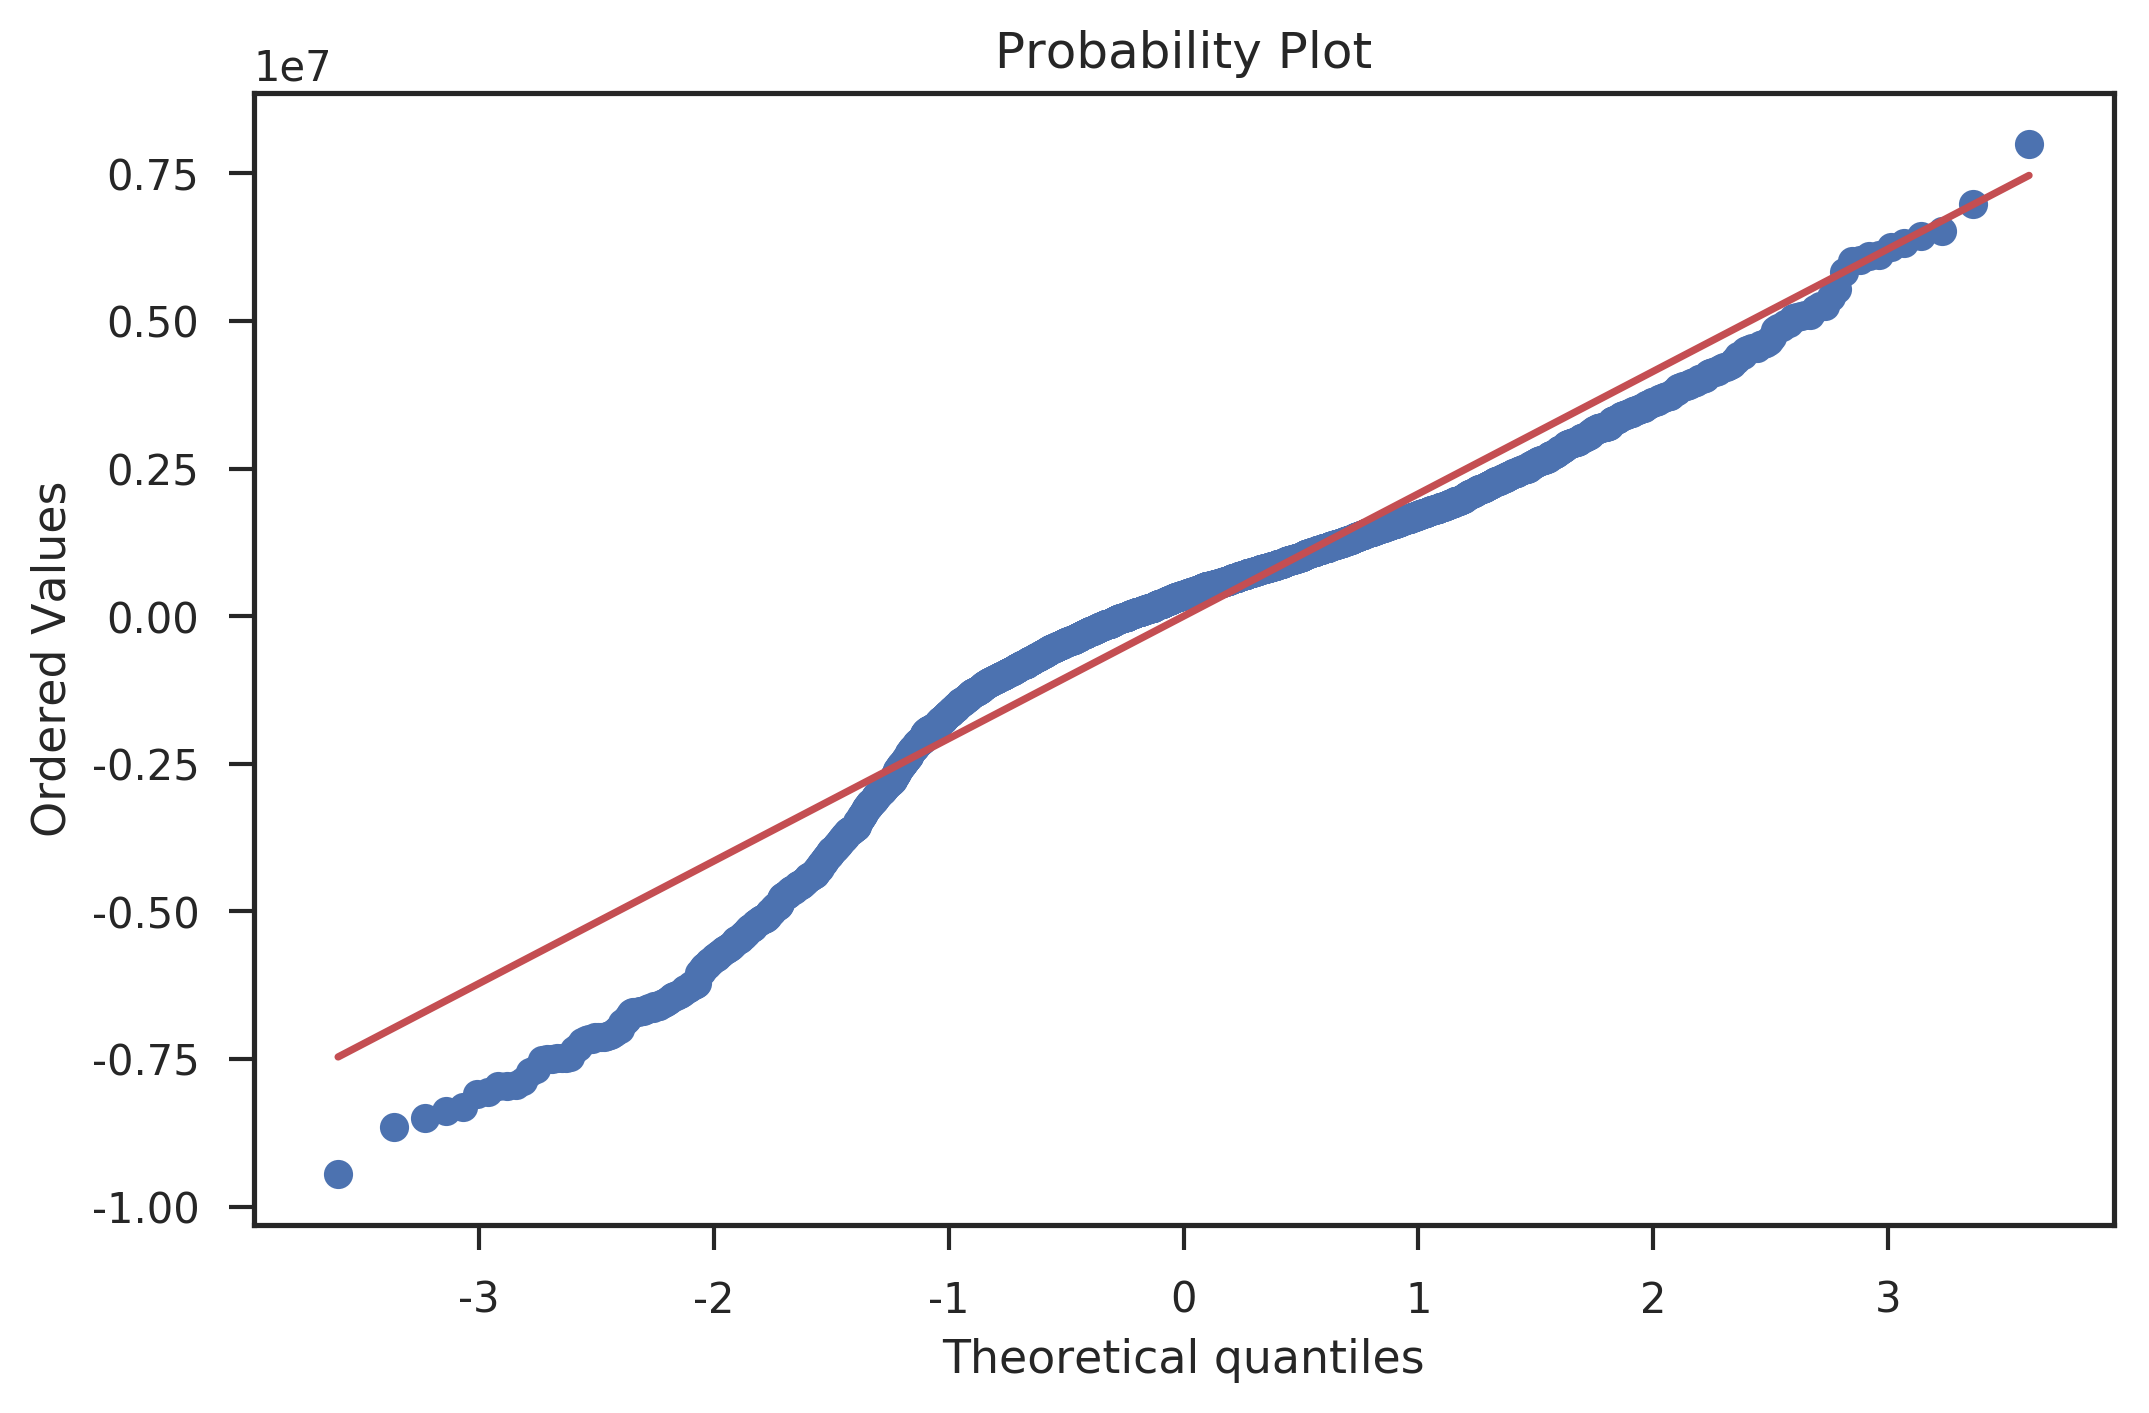

In [66]:
sp.stats.probplot(r_result2.resid, plot=plt)
plt.show()

In [154]:
test = sms.omni_normtest(r_result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 641.312
P-value     :  0.000


In [67]:
train_cor_test_df = pd.concat([num_dum_df_do1, y_do1], axis=1)
train_price_cor_df = abs(train_cor_test_df.corr()[['price_doc']])
train_price_cor_df.sort_values('price_doc', ascending=False)

price_doc
price_doc                               1.000000
full_sq                                 0.750384
life_sq                                 0.641574
num_room                                0.522523
kitch_sq                                0.284241
cafe_sum_5000_min_price_avg             0.193068
cafe_avg_price_5000                     0.189362
cafe_sum_5000_max_price_avg             0.186847
floor                                   0.180056
ttk_km                                  0.179789
max_floor                               0.177510
sadovoe_km                              0.172863
build_count_1971_1995                   0.169626
cafe_sum_3000_min_price_avg             0.165699
leisure_count_500                       0.164728
cafe_avg_price_3000                     0.163362
cafe_sum_3000_max_price_avg             0.161624
build_count_monolith                    0.152680
zd_vokzaly_avto_km                      0.152203
office_sqm_5000                         0.151877
bulvar_ring_km                          0.141754
mosque_km                               0.141123
cafe_sum_2000_min_price_avg             0.138817
cafe_avg_price_2000                     0.137690
sport_count_5000                        0.137238
theater_km                              0.137223
mkad_km                                 0.136985
cafe_sum_2000_max_price_avg             0.136730
kremlin_km                              0.134428
cafe_sum_1500_min_price_avg             0.133517
...                                          ...
detention_facility_km                   0.013344
ts_km                                   0.013302
cafe_count_3000_price_1500              0.013295
16_29_female                            0.012934
cafe_count_3000                         0.012678
industrial_km                           0.012062
market_count_5000                       0.011846
cafe_count_3000_na_price                0.011807
build_count_foam                        0.011175
cemetery_km                             0.011133
cafe_count_2000_price_high              0.010589
mosque_count_3000                       0.008293
additional_education_km                 0.008290
green_part_500                          0.008059
church_count_3000                       0.008050
mosque_count_2000                       0.006861
big_church_count_3000                   0.006369
cafe_count_3000_price_500               0.006098
public_healthcare_km                    0.005643
trc_sqm_2000                            0.005131
sport_count_1000                        0.003979
railroad_1line                          0.003611
mosque_count_500                        0.003579
area_m                                  0.003565
cafe_count_1000_price_1000              0.002328
build_count_slag                        0.002156
school_education_centers_top_20_raion   0.001394
cafe_count_3000_price_4000              0.000315
radiation_raion                         0.000280
incineration_raion                           NaN

[279 rows x 1 columns]

##           
## 2.2 Macro Economic Features
- 2.2.1 Numeric Varialbe Selection
- 2.2.2 Categorical Variable Selection

## Numeric Variable Selection (With Loop)

In [69]:
m_model1, m_result1, m_x1, m_y1 = serial_eli_lim_pval(m_num_dum_df_do1, m_y_do1, ser_1=0.01, ser_2=0.5, ser_3=0.05)

In [70]:
print(m_result1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     39.46
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          1.97e-107
Time:                        11:16:14   Log-Likelihood:            -3.5095e+05
No. Observations:               21291   AIC:                         7.019e+05
Df Residuals:                   21276   BIC:                         7.020e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [72]:
m_result1.params.index

Index(['const', 'micex_rgbi_tr', 'oil_urals', 'pop_natural_increase',
       'invest_fixed_capital_per_cap', 'housing_fund_sqm', 'water_pipes_share',
       'heating_share', 'baths_share', 'marriages_per_1000_cap',
       'hot_water_share', 'lodging_sqm_per_cap', 'divorce_rate',
       'old_house_share', 'mortality', 'real_dispos_income_per_cap_growth',
       'pop_total_inc', 'modern_education_share', 'old_education_build_share',
       'grp_growth', 'students_state_oneshift', 'brent',
       'balance_trade_growth', 'rent_price_4+room_bus',
       'provision_retail_space_sqm', 'pop_migration', 'rent_price_2room_eco',
       'deposits_growth', 'rent_price_1room_eco', 'apartment_fund_sqm',
       'mortgage_value', 'income_per_cap'],
      dtype='object')

In [9]:
m_num_dum_df2_do1 = m_num_dum_df_do1[['micex_rgbi_tr', 'oil_urals',
       'average_provision_of_build_contract_moscow', 'net_capital_export',
       'rent_price_3room_bus', 'construction_value',
       'population_reg_sports_share', 'profitable_enterpr_share',
       'divorce_rate', 'share_own_revenues', 'provision_retail_space_modern_sqm', 'marriages_per_1000_cap',
       'housing_fund_sqm', 'electric_stove_share',
       'hospital_bed_occupancy_per_year', 'unprofitable_enterpr_share',
       'lodging_sqm_per_cap', 'hot_water_share', 'heating_share',
       'water_pipes_share', 'baths_share', 'sewerage_share',
       'incidence_population', 'gas_share', 
       'fin_res_per_cap', 'pop_migration', 'pop_total_inc', 'grp_growth',
       'real_dispos_income_per_cap_growth', 'infant_mortarity_per_1000_cap',
       'child_on_acc_pre_school', 'childbirth',
       'students_state_oneshift', 'pop_natural_increase', 'unemployment',
       'salary_growth', 'power_clinics', 'brent', 'apartment_build',       
       'rent_price_1room_eco', 'mortgage_value', 'income_per_cap']]

In [10]:
m_model2, m_result2, m_x2, m_y2 = serial_eli_lim_pval(m_num_dum_df2_do1, m_y_do1, ser_1=0.0001, ser_2=0.3, ser_3=0.0001)

In [11]:
m_model3, m_result3, m_x3, m_y3 = auto_eli_and_result_print(m_num_dum_df2_do1, m_y_do1, modeltype = 1, lim_=0.01)

In [12]:
print(m_result2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     77.26
Date:                Fri, 24 Nov 2017   Prob (F-statistic):          3.63e-111
Time:                        12:43:22   Log-Likelihood:            -3.5095e+05
No. Observations:               21291   AIC:                         7.019e+05
Df Residuals:                   21283   BIC:                         7.020e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [80]:
print(m_result3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     92.31
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          6.84e-115
Time:                        11:26:30   Log-Likelihood:            -3.5095e+05
No. Observations:               21291   AIC:                         7.019e+05
Df Residuals:                   21284   BIC:                         7.020e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.601e+06 

In [90]:
m_result2.params.index

Index(['const', 'construction_value', 'electric_stove_share',
       'unprofitable_enterpr_share', 'divorce_rate',
       'provision_retail_space_modern_sqm', 'micex_rgbi_tr', 'brent',
       'childbirth', 'rent_price_1room_eco'],
      dtype='object')

##       
## 2.3 Concatednated Features
Get error when put all(train & macro) data into feature selection loop,
  so after 1st treatment of each, then I concat it.

## Data set Restructuring

In [465]:
pd.set_option('display.max_rows', 500)

In [13]:
total_m_dfx = train_mrg_macro_df[['construction_value', 'electric_stove_share',
                                   'unprofitable_enterpr_share', 'divorce_rate',
                                    'micex_rgbi_tr', 'brent', 'childbirth', 'rent_price_1room_eco']] # delete pro ~ (one value)

total_tr_dfx = train_mrg_macro_df[['full_sq', 'kitch_sq', 'product_type', 'build_year',
       'max_floor', 'floor', 'cafe_count_1500_price_4000', 'kremlin_km',
       'leisure_count_500', 'num_room', 'life_sq', 
       'preschool_education_centers_raion', 'cafe_sum_3000_max_price_avg']]

total_num_dfx = pd.concat([total_tr_dfx, total_m_dfx],axis=1)
total_cat_dfx = train_mrg_macro_df[['ecology', 'material']]
total_dfx = pd.concat([total_num_dfx, total_cat_dfx],axis=1)
total_dfx1 = sm.add_constant(total_dfx)
total_y = train_mrg_macro_df[['price_doc']]
total_dfx_y = pd.concat([total_dfx, total_y], axis=1)

In [14]:
t_model1, t_result1 = r_style_from_formula_enc_included(total_num_dfx, total_cat_dfx, total_y, const=1, scal=1)
print(t_result1.summary())

total_dfx1 = sm.add_constant(total_dfx)
total_y_pred = r_result1.predict(total_dfx1)
# rmsle(total_y ,total_y_pred)
np.sqrt(metrics.mean_squared_error(total_y ,total_y_pred))   

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     329.1
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:43:32   Log-Likelihood:                -76577.
No. Observations:                4699   AIC:                         1.532e+05
Df Residuals:                    4670   BIC:                         1.534e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

NameError: name 'r_result1' is not defined

In [ ]:
sp.stats.probplot(t_result1.resid, plot=plt)
plt.show()

## Further Variable drop, manually

## 1 Concatednated Numeric Variable Loop treatment

In [587]:
f_model1, f_result1, f_x1, f_y1 = serial_eli_lim_pval(total_num_dfx, total_y, ser_1=0.00001, ser_2=0.4, ser_3=0.0001)
print(f_result1.summary())

f_x1_con = sm.add_constant(f_x1)
f_y1_new = f_result1.predict(f_x1_con)
np.sqrt(metrics.mean_squared_error(total_y, f_y1_new))  

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     876.6
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:18:06   Log-Likelihood:                -76818.
No. Observations:                4699   AIC:                         1.537e+05
Df Residuals:                    4689   BIC:                         1.537e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

3044527.8179480657

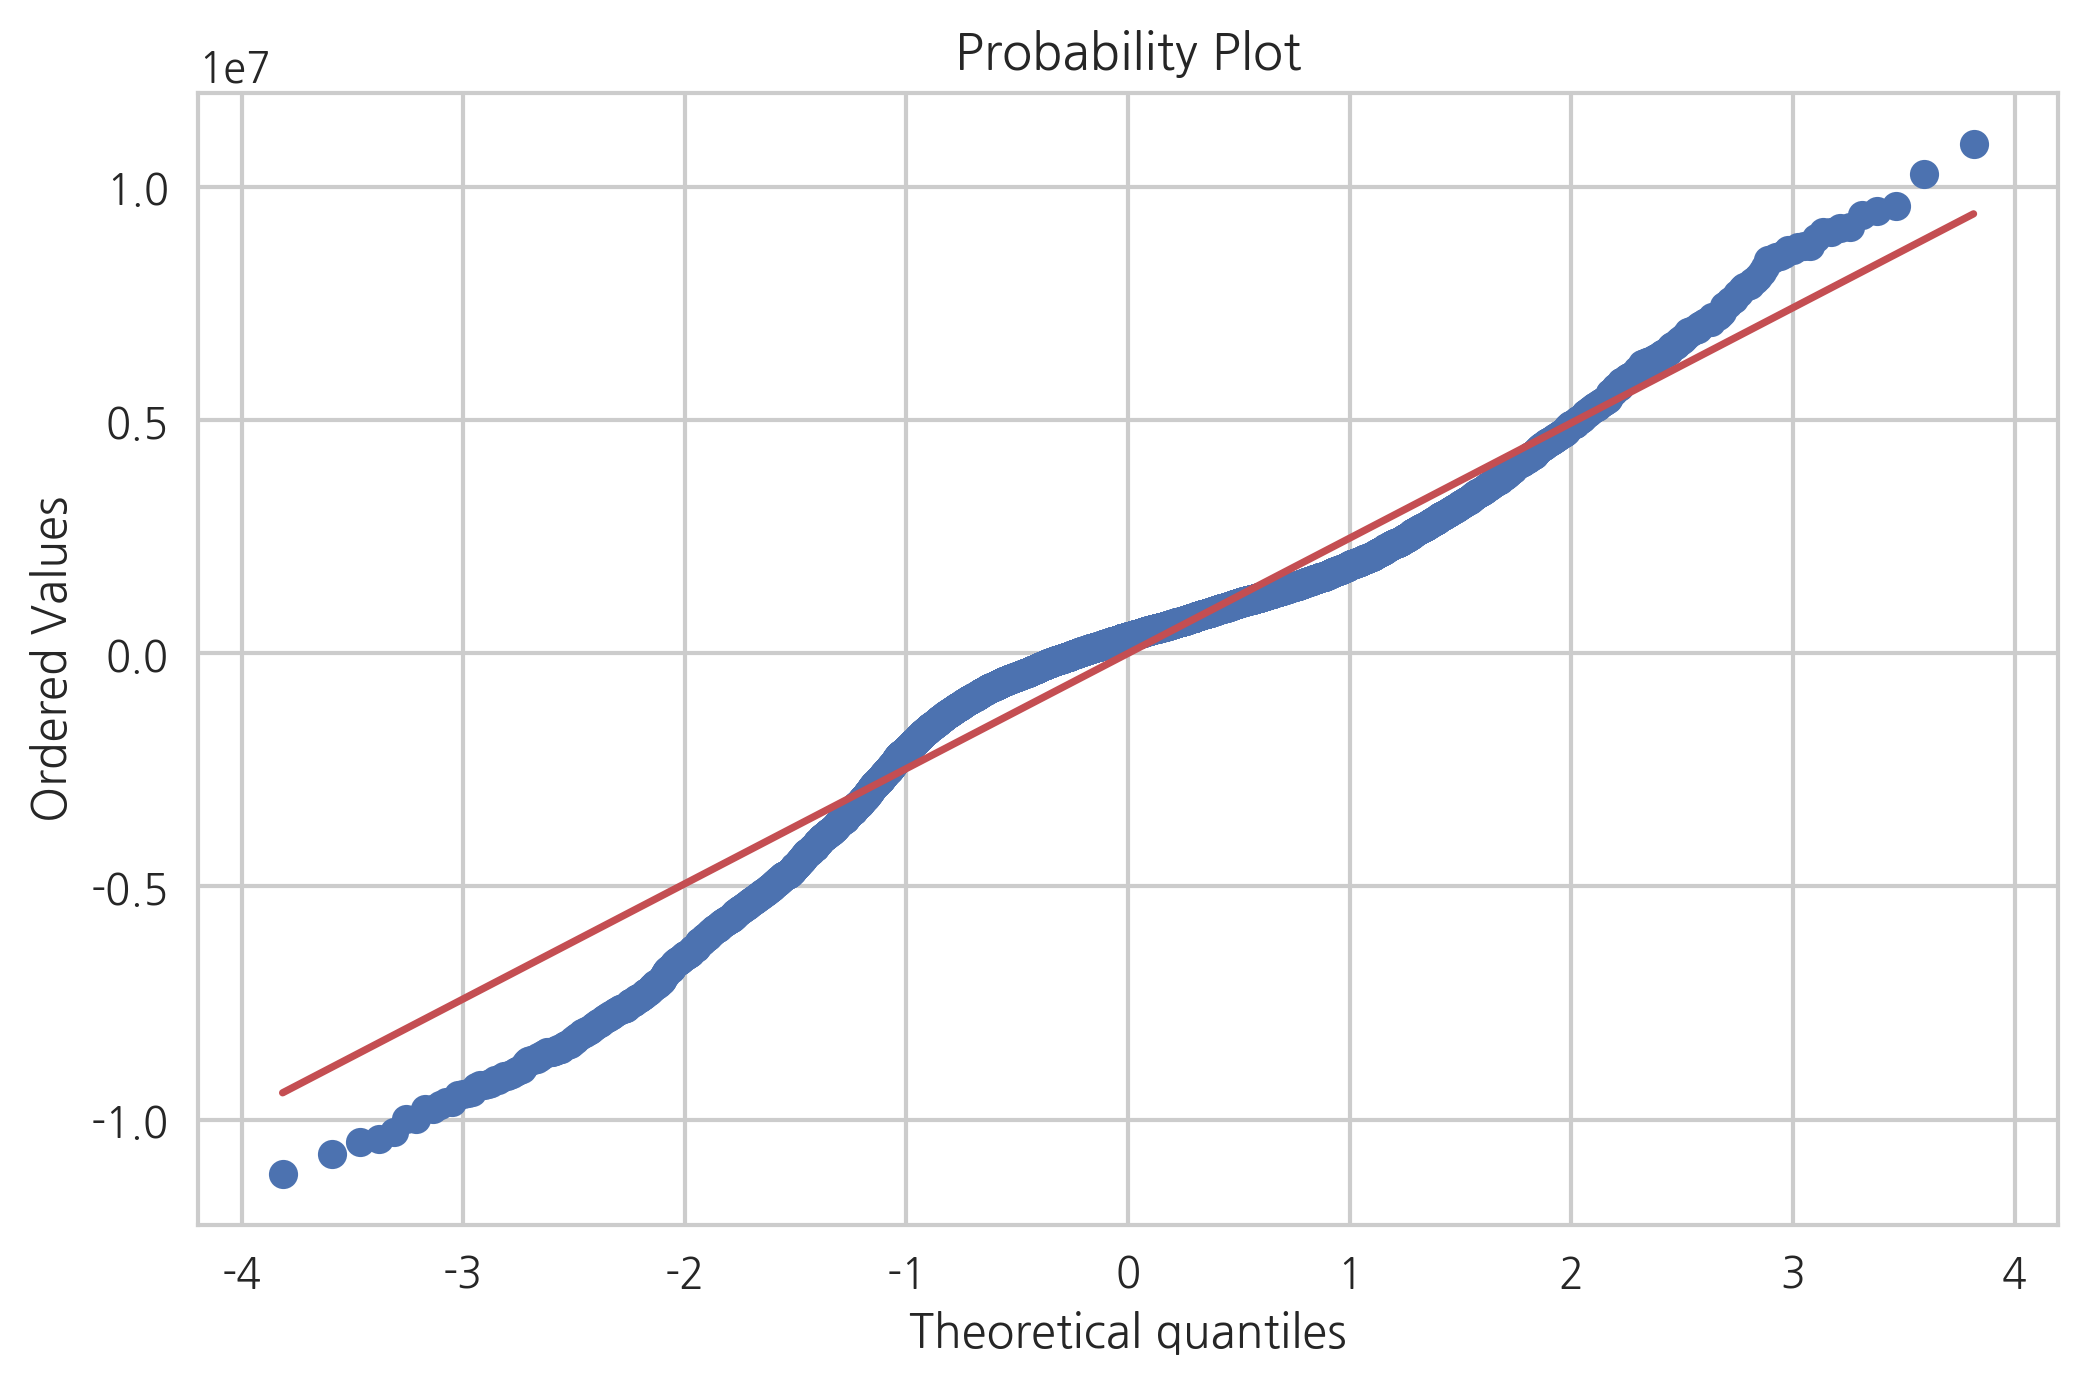

In [269]:
sp.stats.probplot(f_result1.resid, plot=plt)
plt.show()

## 2 Concatednated (Num + Cat) R-Style Loop

In [98]:
f_model2, f_result2 = r_style_from_formula_enc_included(total_num_dfx, total_cat_dfx, total_y, const=1, scal=1)
print(f_result2.summary())

f_y2_new = f_result2.predict(total_dfx1)
np.sqrt(metrics.mean_squared_error(total_y, f_y2_new))  

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     329.1
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        11:53:23   Log-Likelihood:                -76577.
No. Observations:                4699   AIC:                         1.532e+05
Df Residuals:                    4670   BIC:                         1.534e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

2891972.5618377165

## 3 Further Variable Drop & Data Set Restructuring & R-Style Loop

In [15]:
total_num_dfx3 = total_num_dfx.drop(['divorce_rate', 'rent_price_1room_eco', 'electric_stove_share',
                                    'childbirth', 'unprofitable_enterpr_share', 'construction_value', 'max_floor'], axis=1)
total_cat_dfx3 = total_cat_dfx  #.drop(['material'], axis=1)

f_model3, f_result3 = r_style_from_formula_enc_included(total_num_dfx3, total_cat_dfx3, total_y, const=1, scal=1)
print(f_result3.summary())

f_dfx_3 = pd.concat([total_num_dfx3, total_cat_dfx3], axis=1)
f_dfx1_3 = sm.add_constant(f_dfx_3)
f_y3_new = f_result3.predict(f_dfx1_3)
print(np.sqrt(metrics.mean_squared_error(total_y, f_y3_new)))

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     418.7
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:43:38   Log-Likelihood:                -76579.
No. Observations:                4699   AIC:                         1.532e+05
Df Residuals:                    4676   BIC:                         1.534e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

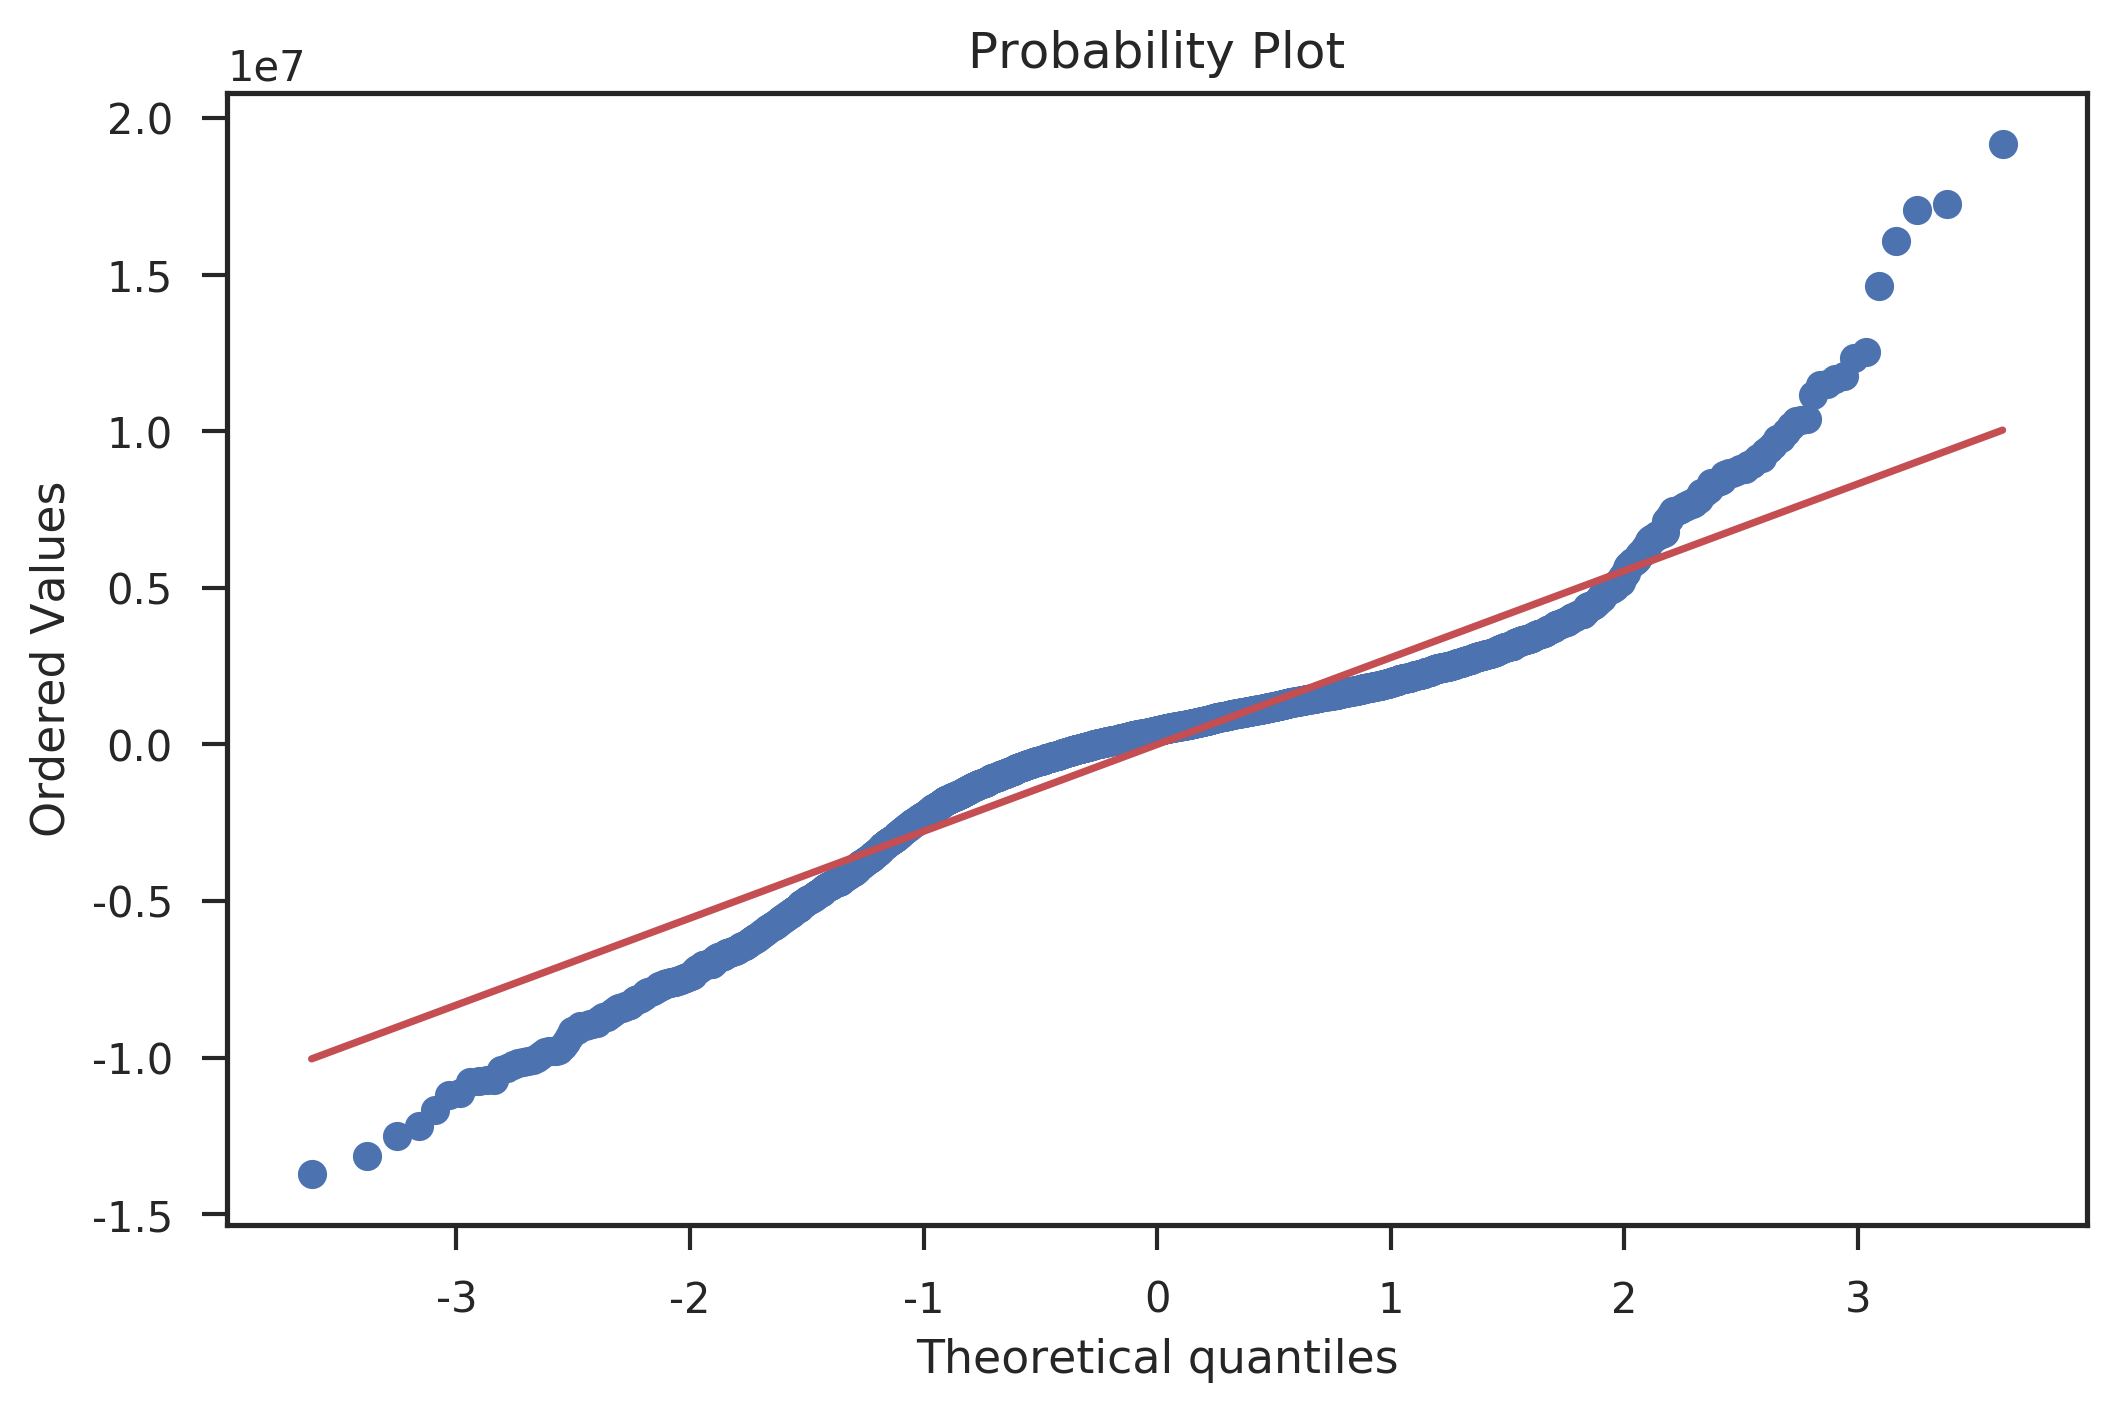

In [102]:
sp.stats.probplot(f_result3.resid, plot=plt)
plt.show()

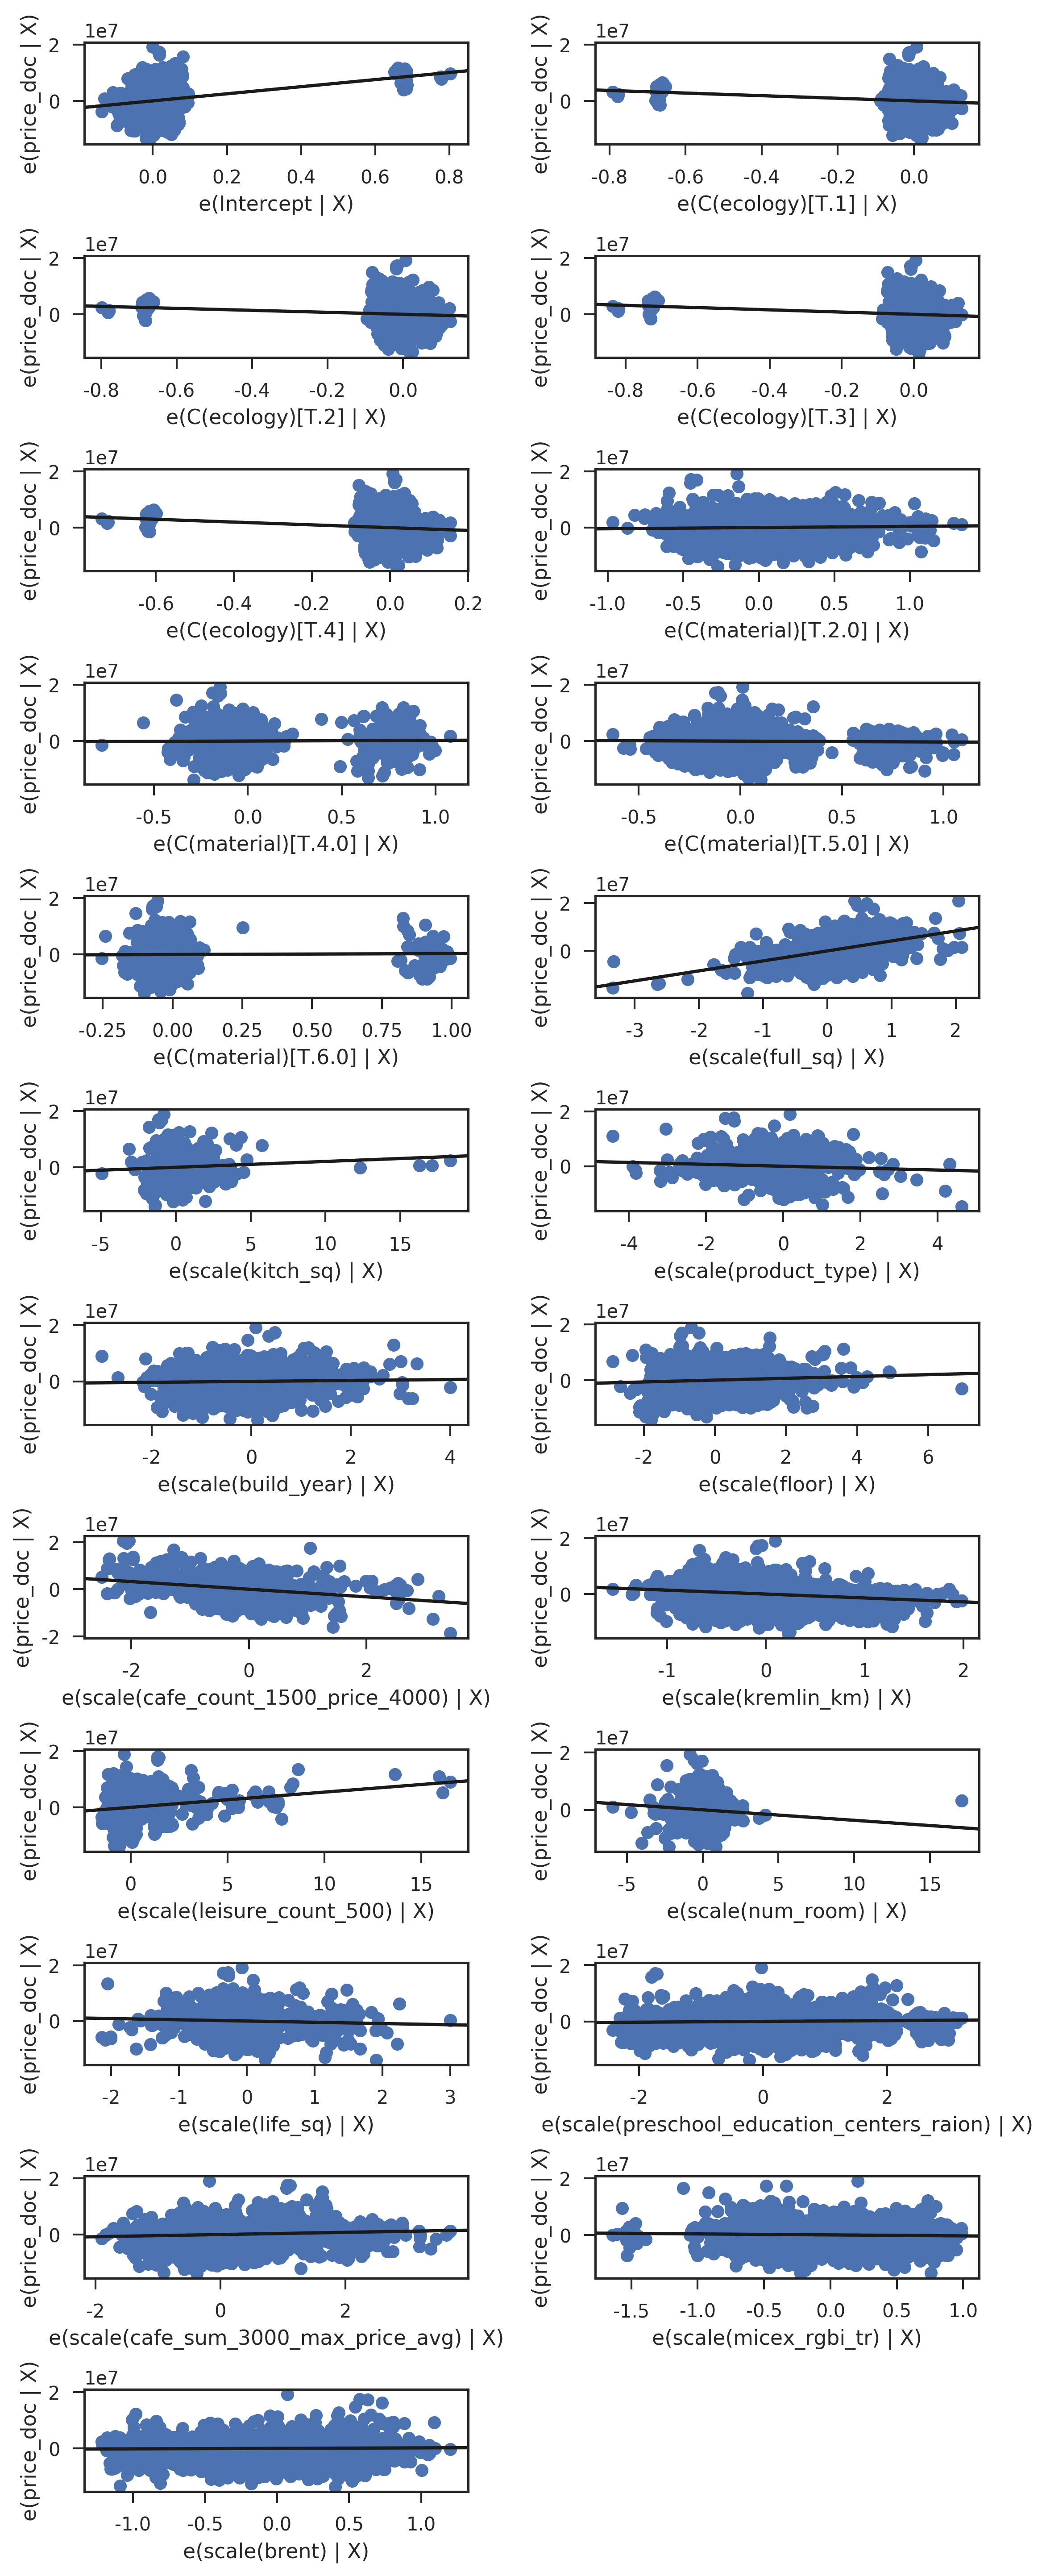

In [106]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(f_result3, fig=fig)
fig.suptitle("")
plt.show()

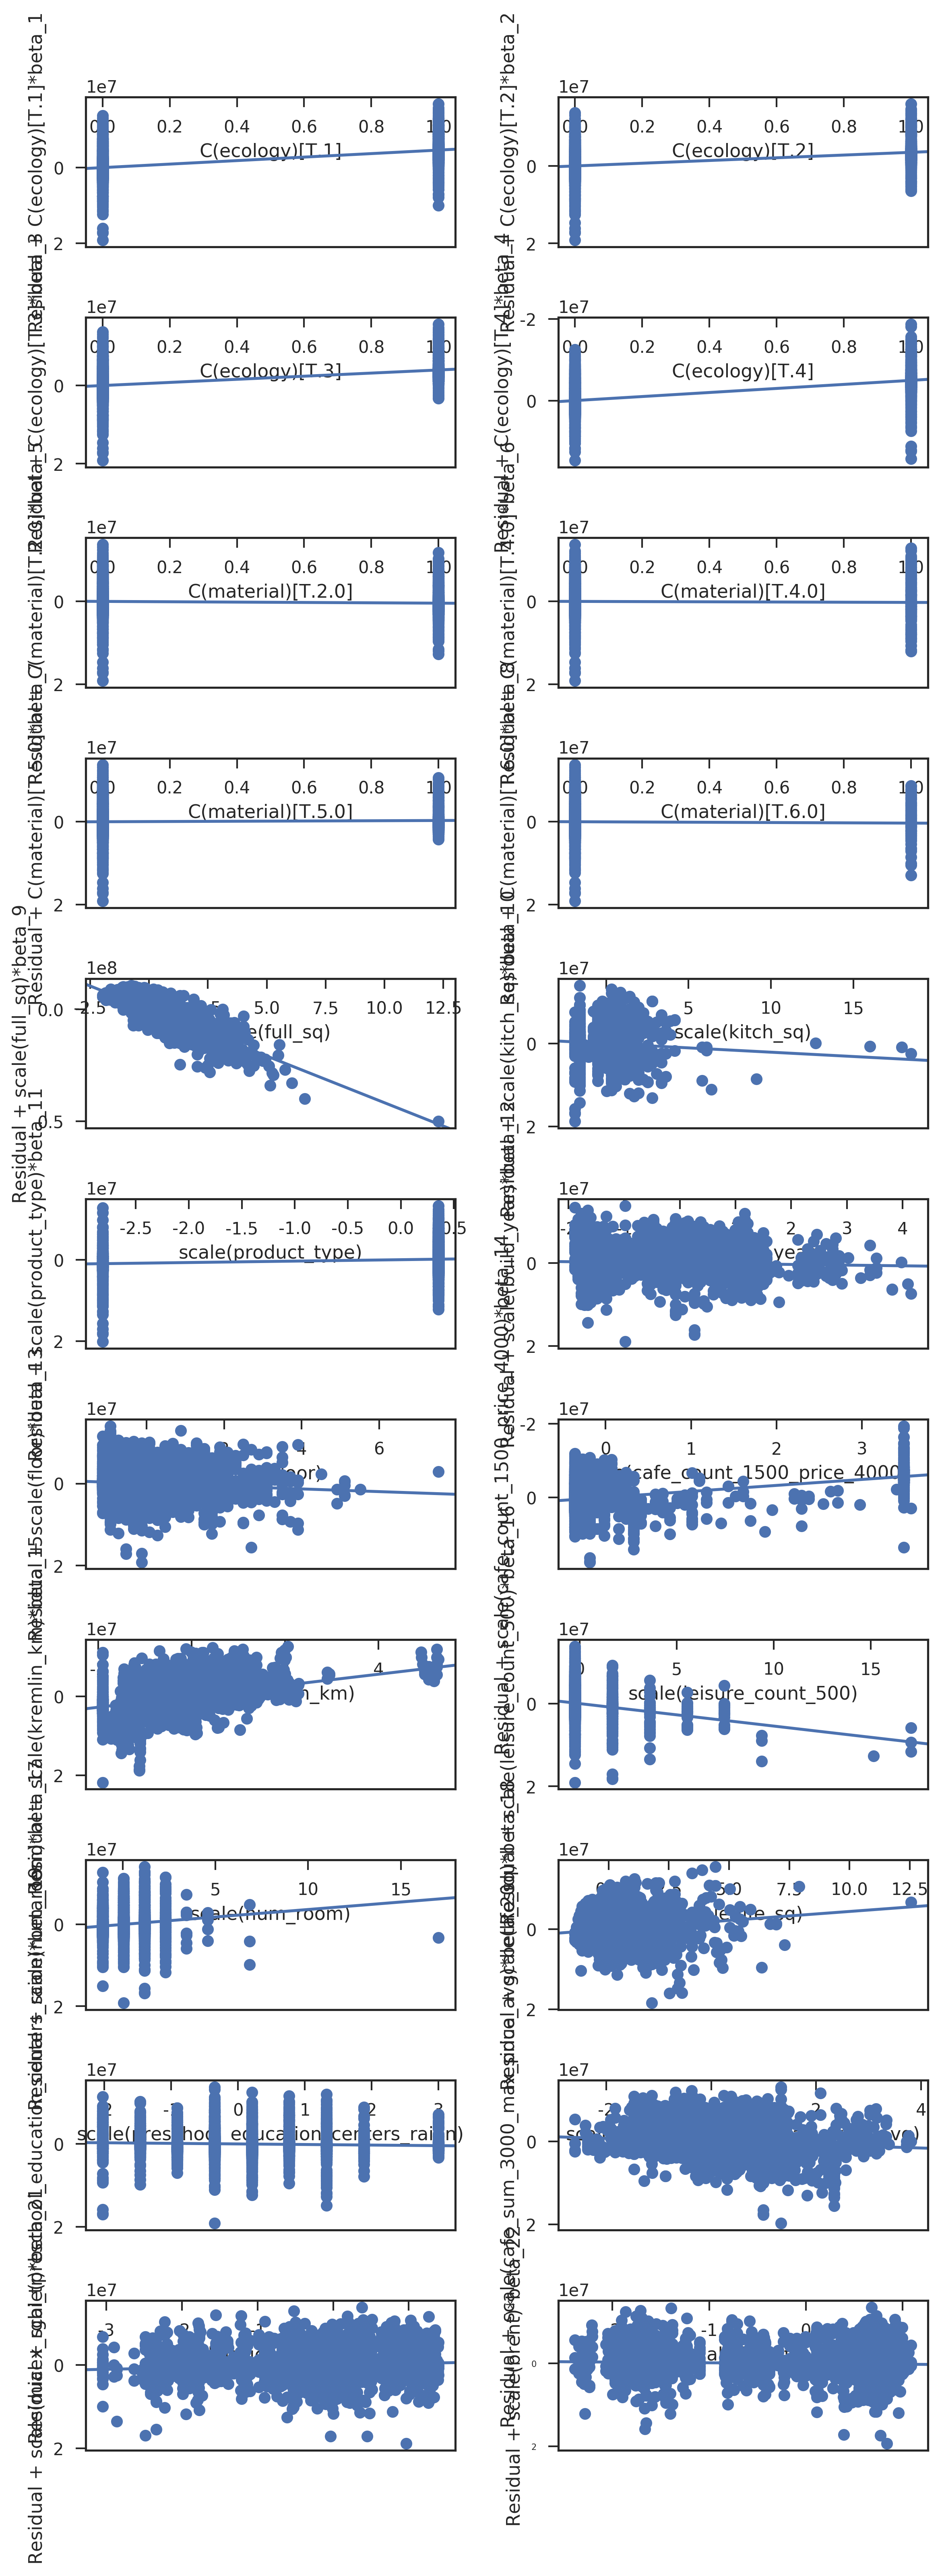

In [112]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_ccpr_grid(f_result3, fig=fig)
plt.yticks(fontsize=5)
fig.suptitle("")
plt.show()

In [115]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(f_dfx_3.values, i) for i in range(f_dfx_3.shape[1])]
vif["features"] = f_dfx_3.columns
vif

VIF Factor                           features
0    80.024873                            full_sq
1     8.980364                           kitch_sq
2    36.584251                       product_type
3     8.214349                         build_year
4     3.561929                              floor
5     3.554663         cafe_count_1500_price_4000
6     8.926011                         kremlin_km
7     1.129904                  leisure_count_500
8    17.480189                           num_room
9    50.960892                            life_sq
10    8.447768  preschool_education_centers_raion
11   77.585381        cafe_sum_3000_max_price_avg
12  267.389428                      micex_rgbi_tr
13   59.685843                              brent
14    5.502591                            ecology
15    2.988613                           material

In [114]:
f_result3.params.index

Index(['Intercept', 'C(ecology)[T.1]', 'C(ecology)[T.2]', 'C(ecology)[T.3]',
       'C(ecology)[T.4]', 'C(material)[T.2.0]', 'C(material)[T.4.0]',
       'C(material)[T.5.0]', 'C(material)[T.6.0]', 'scale(full_sq)',
       'scale(kitch_sq)', 'scale(product_type)', 'scale(build_year)',
       'scale(floor)', 'scale(cafe_count_1500_price_4000)',
       'scale(kremlin_km)', 'scale(leisure_count_500)', 'scale(num_room)',
       'scale(life_sq)', 'scale(preschool_education_centers_raion)',
       'scale(cafe_sum_3000_max_price_avg)', 'scale(micex_rgbi_tr)',
       'scale(brent)'],
      dtype='object')

#    
# 3. Model Optimization & Result
- 3.1 Transformation
- 3.2 Cross-Validation
- 3.3 Test Prediction

## Data Set Restructuring for transformation

In [18]:
trans_num_df = total_num_dfx3
trans_cat_df = total_cat_dfx3
trans_y = np.log(total_y)

trans_dfx = pd.concat([trans_num_df, trans_cat_df], axis=1)
trans_dfx_y = pd.concat([trans_num_df, trans_cat_df, trans_y], axis=1)

## 5 Additional Variable Drop
 **Delete** 'life_sq', 'brent', 'micex_rgbi_tr', 'material'

In [19]:
t_model5 = sm.OLS.from_formula('price_doc ~ scale(full_sq) + scale(kitch_sq) + scale(product_type) + \
                               scale(build_year) + scale(I(floor**2)) + scale(I(cafe_count_1500_price_4000**2)) + \
                               scale(kremlin_km) + scale(leisure_count_500) + scale(num_room) + scale(material) + \
                               scale(preschool_education_centers_raion) + scale(I(cafe_sum_3000_max_price_avg**2)) + \
                               + C(ecology)', data=trans_dfx_y)

t_result5 = t_model5.fit()
print(t_result5.summary())

trans_dfx_1 = sm.add_constant(trans_dfx)
y_new_5 = t_result5.predict(trans_dfx_1)
print(np.sqrt(metrics.mean_squared_error(trans_y, y_new_5)))

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     184.2
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:43:56   Log-Likelihood:                -3476.5
No. Observations:                4699   AIC:                             6987.
Df Residuals:                    4682   BIC:                             7097.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

#    
# Cross Validation
#    

In [20]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


X = trans_dfx.reset_index()
y = trans_y.reset_index().drop(['index'], axis=1)
model = ""

cv = KFold(10)

scores = np.zeros(10)
scores1 = np.zeros(10)
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train = X.loc[train_index, :]
    y_train = y.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_test = y.iloc[test_index, 0]
    
    X_y_train = pd.concat([X_train, y_train], axis=1)
    KFold_result = sm.OLS.from_formula('price_doc ~ scale(full_sq) + scale(kitch_sq) + scale(product_type) + \
                               scale(build_year) + scale(I(floor**2)) + scale(I(cafe_count_1500_price_4000**2)) + \
                               scale(kremlin_km) + scale(leisure_count_500) + scale(num_room) + scale(material) + \
                               scale(preschool_education_centers_raion) + scale(I(cafe_sum_3000_max_price_avg**2)) + \
                               + C(ecology)', data=X_y_train).fit()
    X1_test = sm.add_constant(X_test)
    y_pred = KFold_result.predict(X_test)
    scores[i] = np.sqrt(mean_squared_error(y_test, y_pred))
    scores1[i] = rmsle(y_test, y_pred)

print(scores)
print(scores1)

[ 0.47397056  0.50850603  0.49159234  0.49423221  0.55453143  0.53851967
  0.50933899  0.53060512  0.51911749  0.47199911]
[ 0.02948266  0.03158134  0.03065026  0.03013329  0.03443961  0.03351282
  0.0315436   0.03302052  0.03205088  0.02892915]


In [21]:
print(scores.mean())
print(scores1.mean())

0.509241295986
0.0315344118535


In [123]:
total_y.price_doc.median()

7200000.0

# Final Model Check

In [22]:
t_model6 = sm.OLS.from_formula('price_doc ~ scale(full_sq) + scale(kitch_sq) + scale(product_type) + \
                               scale(build_year) + scale(I(floor**2)) + scale(I(cafe_count_1500_price_4000**2)) + \
                               scale(kremlin_km) + scale(leisure_count_500) + scale(num_room) + scale(material) + \
                               scale(preschool_education_centers_raion) + scale(I(cafe_sum_3000_max_price_avg**2)) + \
                               + C(ecology)', data=trans_dfx_y)

t_result6 = t_model6.fit()
print(t_result6.summary())

trans_dfx_1 = sm.add_constant(trans_dfx)
y_new_6 = t_result6.predict(trans_dfx_1)
print(np.sqrt(metrics.mean_squared_error(trans_y, y_new_6)))

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     184.2
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        12:45:03   Log-Likelihood:                -3476.5
No. Observations:                4699   AIC:                             6987.
Df Residuals:                    4682   BIC:                             7097.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [23]:
regul_result1 = t_model6.fit_regularized(alpha=0.01, L1_wt=1)
# print(regul_result1.summary())

y_regul_new1 = regul_result1.predict(trans_dfx_1)
print(np.sqrt(metrics.mean_squared_error(trans_y, y_regul_new1)))

0.509784332032


#   
# Test
#     

In [28]:
test_tr_df = pd.read_csv('datasets/processed_data/test_tr1_df.csv')
test_tr_df.shape

(8901, 292)

In [29]:
test_tr_df_enc = encode_cat(test_tr_df)

In [34]:
test_tr_df_enc_1 = sm.add_constant(test_tr_df_enc)
y_pred = np.exp(t_result6.predict(test_tr_df_enc_1))
y_regul_pred =np.exp(regul_result1.predict(test_tr_df_enc_1))
y_setting = pd.to_numeric(y_pred.apply(lambda x : '{0:.2f}'.format(x)))

In [33]:
np.exp(y_pred)

0       6.962687e+06
1       7.808669e+06
2       1.402328e+07
3       8.468446e+06
4       7.654563e+06
5       9.148696e+06
6       1.192207e+07
7       8.104938e+06
8       5.358129e+06
9       6.794663e+06
10      1.775773e+07
11      6.276463e+06
12      6.845440e+06
13      5.136235e+06
14      9.331610e+06
15      8.506626e+06
16      7.283188e+06
17      1.222416e+07
18      1.209294e+07
19      5.734028e+06
20      6.255570e+06
21      1.780400e+07
22      8.328634e+06
23      6.710505e+06
24      7.402202e+06
25      6.738028e+06
26      5.884155e+06
27      1.215700e+07
28      1.366194e+07
29      6.457293e+06
            ...     
8871    1.640119e+07
8872    5.655271e+06
8873    7.453412e+06
8874    3.365526e+07
8875    8.128742e+06
8876    6.938365e+06
8877    1.171424e+07
8878    1.328825e+07
8879    7.643210e+06
8880    7.495112e+06
8881    7.883959e+06
8882    9.878282e+06
8883    8.246332e+06
8884    9.360139e+06
8885    1.151631e+07
8886    8.009154e+06
8887    8.917

In [35]:
id_df = test_tr_df['id'].apply(lambda x: int(x))
final_answer = pd.concat([id_df, y_setting], axis=1)
final_answer.columns = ['id', 'predictions']

In [36]:
final_answer.dtypes

id               int64
predictions    float64
dtype: object

In [305]:
# '%1.1f + %1.1f / (%1.1f * %1.1f)'
np.savetxt(r'destaurant_answer.txt', final_answer.values, fmt='%d,%.2f', newline='\n', header='id,price_doc')

#   
#  Test Answer - Prediction Compare
#    

In [38]:
test_answer_df = pd.read_csv('datasets/processed_data/test_answer_sberbank_housing.csv')

In [39]:
y_answer = test_answer_df['price_doc']
y_final_pred = final_answer['predictions']

In [40]:
print(np.sqrt(mean_squared_error(y_answer, y_final_pred)))
print(rmsle(y_answer, y_final_pred))
print(np.sqrt(mean_squared_error(y_answer, y_regul_pred)))
print(rmsle(y_answer, y_regul_pred))

26574051623.4
0.753775066309
12257725080.1
0.556106486413


In [145]:
y_answer_y_final_pred_df = pd.concat([y_answer, y_final_pred], axis=1)
y_answer_y_final_pred_df

price_doc  predictions
0       5850000  16683473.90
1       5700000  17797275.06
2       9100000  23262647.91
3       1850000  18114133.81
4       5900000  17552336.02
5       7900000  19131418.17
6       8200000  22259998.65
7       6250000  18137422.31
8       5750000  13829937.69
9       6000000  16046147.09
10     18300000  24701908.28
11      4850000  15754672.29
12      5700000  16436409.33
13      4300000  14054678.51
14      6200000  19711382.33
15      7500000  18352909.79
16      5900000  16993281.31
17      9550000  21744608.75
18      8600000  21712766.27
19      4833000  14707036.34
20      4800000  15431352.26
21     14000000  25202790.80
22      8400000  18307973.52
23      2080000  16088861.89
24      5750000  17040888.98
25      6600000  16487802.32
26      5300000  14680700.47
27      2630000  21821206.01
28      2600000  23342299.41
29      4550000  15954876.32
...         ...          ...
8871    8431390  25898554.16
8872    4480333  15385003.99
8873    7500000  16576392.20
8874   38400000  32457395.66
8875    7000000  17128861.21
8876    5100000  16074475.97
8877    6598943  21630613.24
8878   11500000  22727661.39
8879    7700000  17476043.87
8880    1000000  16390183.71
8881    7500000  16738792.49
8882    7700000  19136314.17
8883    4514812  17748838.51
8884    8000000  19122109.72
8885   10000000  20571008.62
8886    6321515  17954417.26
8887    3624440  19599671.48
8888    7127255  24038868.84
8889    6200000  15526355.09
8890    6700000  15475374.16
8891   17200000  24674874.24
8892    6700000  16494146.94
8893   10139368  22827200.78
8894    6373324  21833629.73
8895    9227657  22386180.87
8896    6300000  16592742.42
8897    9014972  25326482.21
8898    5000000  17801836.07
8899    6750554  16307277.86
8900   25000000  27618984.21

[8901 rows x 2 columns]

# Automation of 
 auto_eli_and_result_print를 사용하실 경우 print문을 막고 진행하시길 바랍니다.
 너무 무거워서 50이상일 경우 오래걸림.

In [ ]:
auto_result_dict = {}
for i in range(2):
    modeltype = 0; ser_1 = np.random.random_sample()/100; ser_2 = np.random.random_sample()*6/10 + 0.4; 
    ser_3 = np.random.random_sample()/100; lim_ = np.random.random_sample()*5/100
    
    model, result, x, y = auto_eli_and_result_print(num_dum_df_do1, y_do1, modeltype, ser_1, ser_2, ser_3, lim_)
    temp_list = [ser_1, ser_2, ser_3, len(result.params.index), result.rsquared, result.rsquared_adj, result.condition_number]
    auto_result_dict[i] = temp_list